The mean field $\alpha - \Omega $ dynamo equation in the kinematic region that we solved in the task2 is as follows:

Now making the same equations dimensionless, we get:
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= \left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] - \frac{\pi^2 \bar{B}_r}{4} - \frac{2}{\pi}\alpha \bar{B}_\phi, \\
& \frac{\partial \bar{B}_\phi}{\partial t}=\left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] - \frac{\pi^2}{4}\bar{B_\phi} + r\frac{d\Omega}{dr}  \bar{B}_r\\
\end{aligned}
\end{aligned}
$$

Now ignoring th radial deriatives we have only the alpha term to deal with:
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= - \frac{\pi^2 \bar{B}_r}{4} - \frac{2}{\pi}\alpha \bar{B}_\phi, \\
& \frac{\partial \bar{B}_\phi}{\partial t}= - \frac{\pi^2}{4}\bar{B_\phi} \\
\end{aligned}
\end{aligned}
$$


#### Some Definations

In [1]:
# Librarires
import numpy as np
import matplotlib.pyplot as plt

#Define Constants
omega_0 = 300
h0= 0.5

#Define radial grid parameters
r_min = 0.01   # Minimum radial coordinate
r_max = 10.0   # Maximum radial coordinate
Nr = 100      # Number of grid points
r_values = np.linspace(r_min, r_max, Nr) # Create radial grid
dr= (r_max - r_min)/Nr

#Define Time parameters
t_min = 0
t_max = 4
Nt = 10000 
t_values= np.linspace(t_min,t_max,Nt)
dt = (t_max - t_min)/Nt

# Define the number of ghost zones
num_ghost_zones = 5

#extend the grid
r_min_new= r_min- num_ghost_zones*dr
r_max_new =  r_max + num_ghost_zones*dr

Nr_new= Nr+ 2*num_ghost_zones+1
r_values= np.linspace(r_min_new,r_max_new,Nr_new)
Nr=Nr_new
#Define spatial dependence of Ω and α.
omega = omega_0 / (1+(r_values/2)**2)**0.5

In [2]:
def DynamoNumber(alph):
    q = -(r_values/omega) * np.gradient(omega, r_values)
    D = - alph * q * omega * h0**3
    print("Dynamo Number =", np.mean(D))

#### Plot the initial magnetic fields

In [3]:
#Define initial seed magnetic field
Br_Orig = np.sin(np.pi*(r_min-r_values)/(r_max-r_min))
Bphi_Orig = (-1)*np.sin(np.pi*(r_min-r_values)/(r_max-r_min))

#### Coupled Equations to be Solved

In [4]:
#Define coupled equations
def coupled(B_r,B_phi,alpha):
    dBr_dt= - (np.pi**2 *B_r)/(4) - (2/np.pi)*alpha*B_phi
    dBphi_dt= - (np.pi**2 *B_phi)/(4)
    return np.array([dBr_dt,dBphi_dt])

#### RK4 Method

In [5]:
def rk4_step(B__r,B__phi,alpha):
    k1 = dt * coupled(B__r, B__phi,alpha)
    k2 = dt * coupled(B__r + 0.5 * k1[0], B__phi + k1[1] * 0.5,alpha)
    k3 = dt * coupled(B__r + 0.5 * k2[0], B__phi + k2[1] * 0.5,alpha)
    k4 = dt * coupled(B__r + k3[0], B__phi + k3[1],alpha)

    X = B__r + (k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) / 6
    Y = B__phi + (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) / 6
    
    #Define BCs
    X[5]=0
    X[-6]=0
    Y[-6]=0
    Y[5]=0
    
    for iter in range(num_ghost_zones):
        X[5-iter]=X[5+iter]
        Y[5-iter]=Y[5+iter]
        X[-6+iter]=X[-6-iter]
        Y[-6+iter]=X[-6-iter]
    return X,Y

#### Plotting the Initial Magnetic fields

In [6]:
def InitialPlot():
    # Plot Br
    plt.figure(figsize=(16, 9))
    plt.subplot(1, 2, 1)
    plt.plot(r_values, Br_Orig, color='blue')
    plt.title(r'$B_r$ Vs Radial Distance')
    plt.xlabel('Radial Distance (kpc)')
    plt.ylabel(r'$B_r (\mu G)$')
    plt.grid(True)
    plt.axvline(x=r_min, color='r', linestyle='--', linewidth=2, label='Vertical Line')
    plt.axvline(x=r_max, color='r', linestyle='--', linewidth=2, label='Vertical Line')

    # Plot Bphi
    plt.subplot(1, 2, 2)
    plt.plot(r_values, Bphi_Orig, color='red')
    plt.title(r'$B_\phi$ Vs Radial Distance')
    plt.xlabel('Radial Distance (kpc)')
    plt.ylabel(r'$B_\phi (\mu G)$')
    plt.grid(True)
    plt.axvline(x=r_max, color='blue', linestyle='--', linewidth=2, label='Vertical Line')
    plt.axvline(x=r_min, color='blue', linestyle='--', linewidth=2, label='Vertical Line')

    plt.tight_layout()
    plt.show()

#### Plotting the evolution of $B_\phi$ & $B_r$ at time steps for a given spatial point.

In [7]:
def MagVsTime(Br_Evolution_t,Bphi_Evolution_t):        
    # Plot the evolution of magnetic field at different radial positions over time
    plt.figure(figsize=(16,9))
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(t_min, t_max, Nt + 1),np.abs(Br_Evolution_t[:, ::Nr//10]))
    plt.xlabel('Radial Distance (in kpc)')
    plt.ylabel('Br')
    plt.title('Evolution of Br at Different Radial Positions (RK Method)')
    plt.legend([f'Time = {t * dt:.2f}' for t in range(0, Nt + 1, Nt // 10)])
    plt.tight_layout()

    # Plot the evolution of magnetic field at different radial positions over time
    plt.subplot(1, 2, 2)
    plt.plot(np.linspace(t_min, t_max, Nt + 1),np.abs(Bphi_Evolution_t[:, ::Nr//10]))
    plt.xlabel('Radial Distance (in kpc)')
    plt.ylabel('Bphi')
    plt.title('Evolution of B_phi at Different Radial Positions (RK Method)')
    plt.legend([f'Time = {t * dt:.2f}' for t in range(0, Nt + 1, Nt // 10)])
    plt.tight_layout()
    plt.show()

#### Plotting the evolution of $B_\phi$ & $B_r$ at radial distance for a given time.

In [8]:
# Store the evolution of magnetic field at different radial positions
def MagVsRadial(Br_Evolution,Bphi_Evolution): 
    plt.figure(figsize=(16, 9))
    plt.subplot(1, 2, 1)
    for t in range(0, Nt + 1, Nt // 10):  # Plot every 10th time step
        plt.plot(r_values, Br_Evolution[t, :])#, label=f'Time = {t * dt:.2f}')
    plt.xlabel('Time (in Myr)')
    plt.ylabel(r'$B_r (\mu G)$')
    plt.title(r'Spatial Solution for $B_r$ at Different Time Steps')
    plt.legend([f'r={r_values[i]:.2f}' for i in range(0, Nr, Nr//10)])
    #plt.legend()
    plt.axvline(x=r_min, color='r', linestyle='--', linewidth=2, label='Vertical Line')
    plt.axvline(x=r_max, color='r', linestyle='--', linewidth=2, label='Vertical Line')
    plt.tight_layout()
    

    # Plot the spatial solution for Bphi
    plt.subplot(1, 2, 2)
    for t in range(0, Nt + 1, Nt // 10):  # Plot every 10th time step
        plt.plot(r_values, Bphi_Evolution[t, :])#, label=f'Time = {t * dt:.2f}')
    plt.xlabel('Time (in Myr)')
    plt.ylabel(r'$B_\phi (\mu G)$')
    plt.title(r'Spatial Solution for $B_\phi$ at Different Time Steps')
    plt.legend([f'r={r_values[i]:.2f}' for i in range(0, Nr, Nr//10)])
    #plt.legend()
    plt.axvline(x=r_min, color='r', linestyle='--', linewidth=2, label='Vertical Line')
    plt.axvline(x=r_max, color='r', linestyle='--', linewidth=2, label='Vertical Line')
    plt.tight_layout()
    plt.show()

#### Plotting $Log_{10} \left(\sqrt{B_r^2 + B_\phi^2}\right)$ Vs Time)

In [9]:
# Seems slightly complicated but let's get on with it
def LogB_T(Br_Evolution,Bphi_Evolution):
    result=[]
    for i in range(len(Br_Evolution)):
        test = 0
        for j in range(len(Br_Evolution[0])):
            test = test + (Br_Evolution[i][j]**2 + Bphi_Evolution[i][j]**2)**0.5
        result.append(test/len(Br_Evolution[0]))

    plt.figure(figsize=(12, 6))
    plt.plot(np.linspace(0, t_max, Nt + 1),np.log10(np.abs(result)))
    plt.xlabel('Time (in Myr)')
    plt.ylabel(r'$\log_{10}(B) (\mu G)$')
    plt.title(r'$Log_{10} \left(\sqrt{B_r^2 + B_\phi^2}\right)$ Vs Time')
    #plt.legend([f'r={r_values[i]:.2f}' for i in range(0, Nr, Nr//10)])
    plt.tight_layout()
    plt.show()

#### Finding the Global Gamma

For different values of alpha, the slope of the tail of Log(B) Vs time plot is taken. 
Whenever the slope changes sign from negative to positive. 
The corresponding two alpha values is used to calculate the average alpha, which is further used to find the critical Dynamo Number.

#### Pitch Angle

In [10]:
def Pitch(Br_Evolution,Bphi_Evolution):
    # Function to compute the pitch angle
    def Pitch_angle(Br, Bphi):
        return np.arctan2(Br, Bphi)

    # Store the evolution of pitch angle at different time steps
    evolution_pitch = np.zeros((Nt + 1, Nr))

    # Time-stepping scheme using Runge-Kutta
    for t in range(Nt + 1):
        evolution_pitch[t, :] = Pitch_angle(Br_Evolution[t, :], Bphi_Evolution[t, :])

    # Plot the spatial solution for the pitch angle
    plt.figure(figsize=(20, 6))
    for t in range(0, Nt + 1, Nt // 10):  # Plot every 10th time step
        plt.plot(r_values, evolution_pitch[t, :], label=f'Time = {t * dt:.2f}')
    plt.xlabel('Radial Distance (in kpc)')
    plt.ylabel('Pitch Angle (in radians)')
    plt.title('Spatial Solution for Pitch Angle at Different Time Steps')
    plt.legend()
    plt.tight_layout()
    plt.axvline(x=r_min, color='r', linestyle='--', linewidth=2, label='Vertical Line')
    plt.axvline(x=r_max, color='r', linestyle='--', linewidth=2, label='Vertical Line')
    plt.show()

# Finally calling the equations to get the output

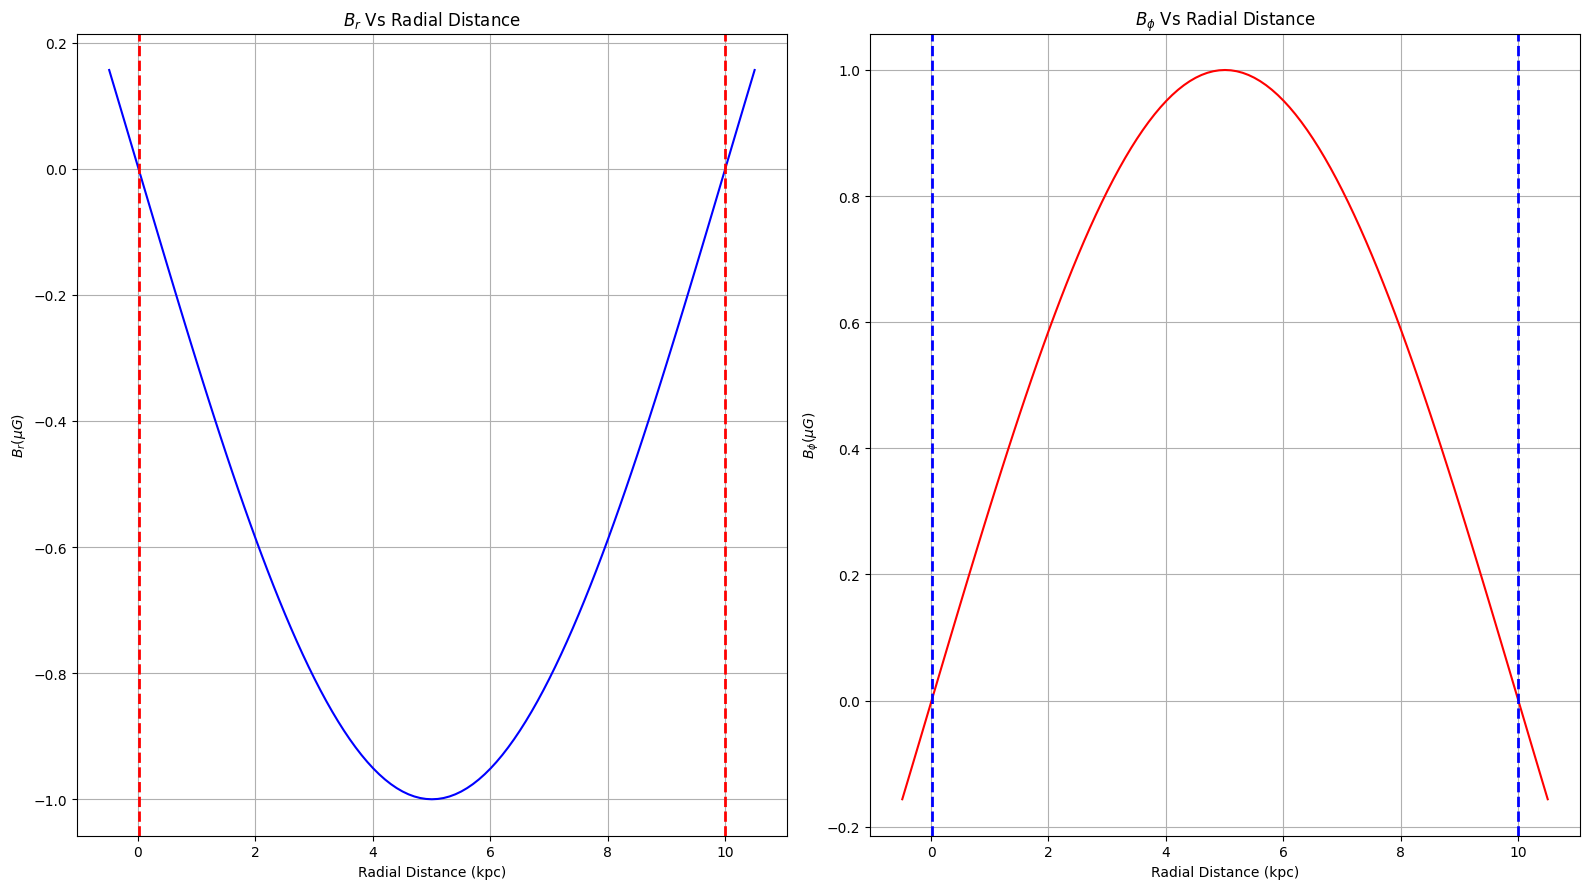

For alpha value= 1 



Dynamo Number = -9.38996658306813


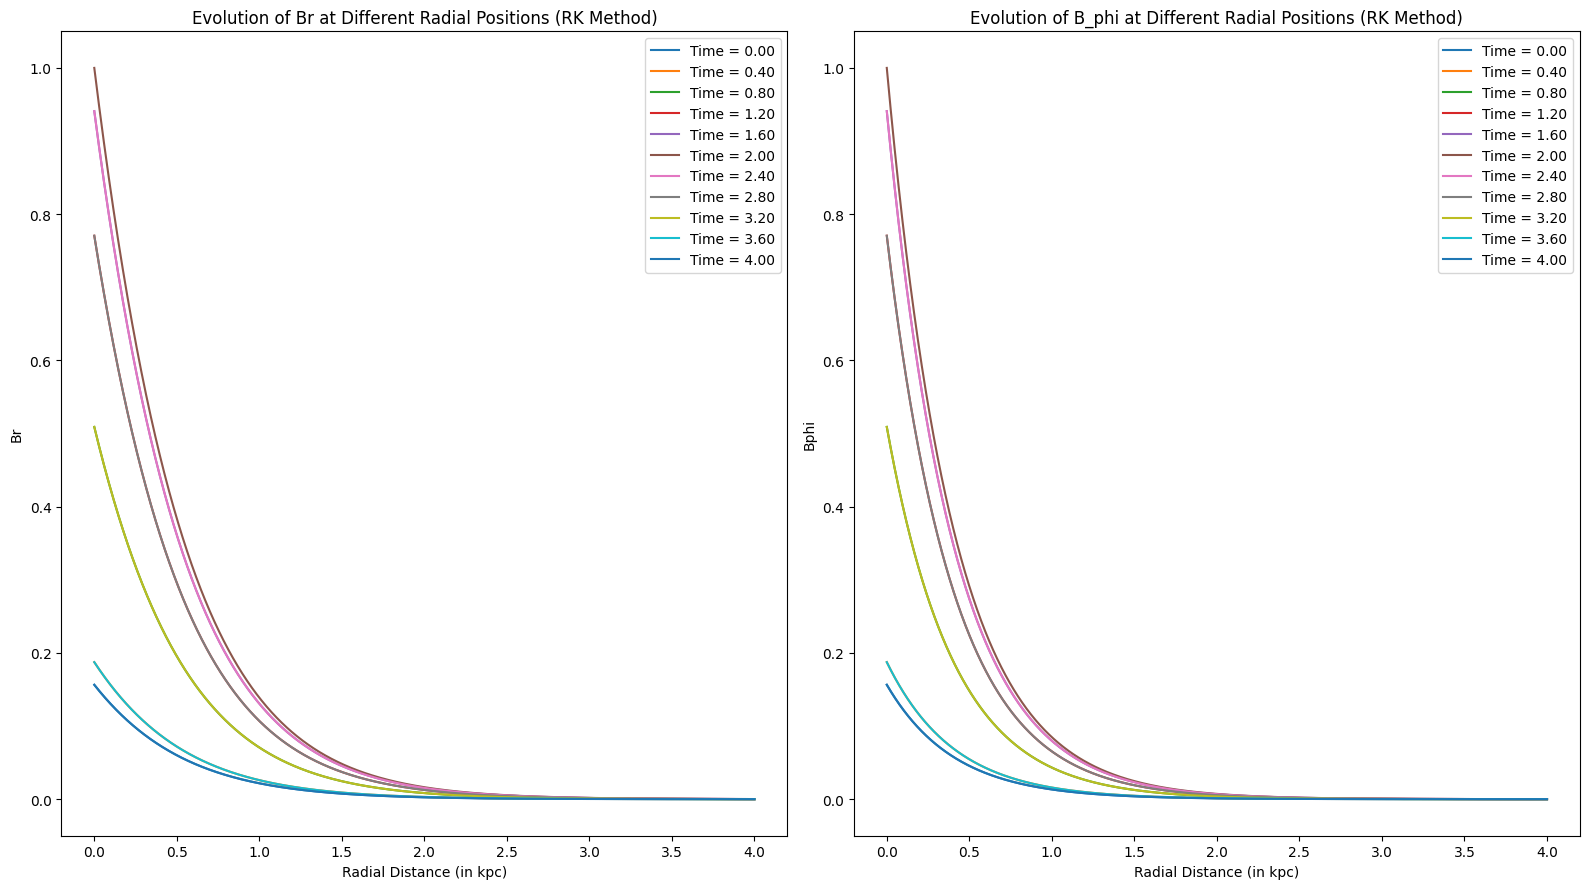

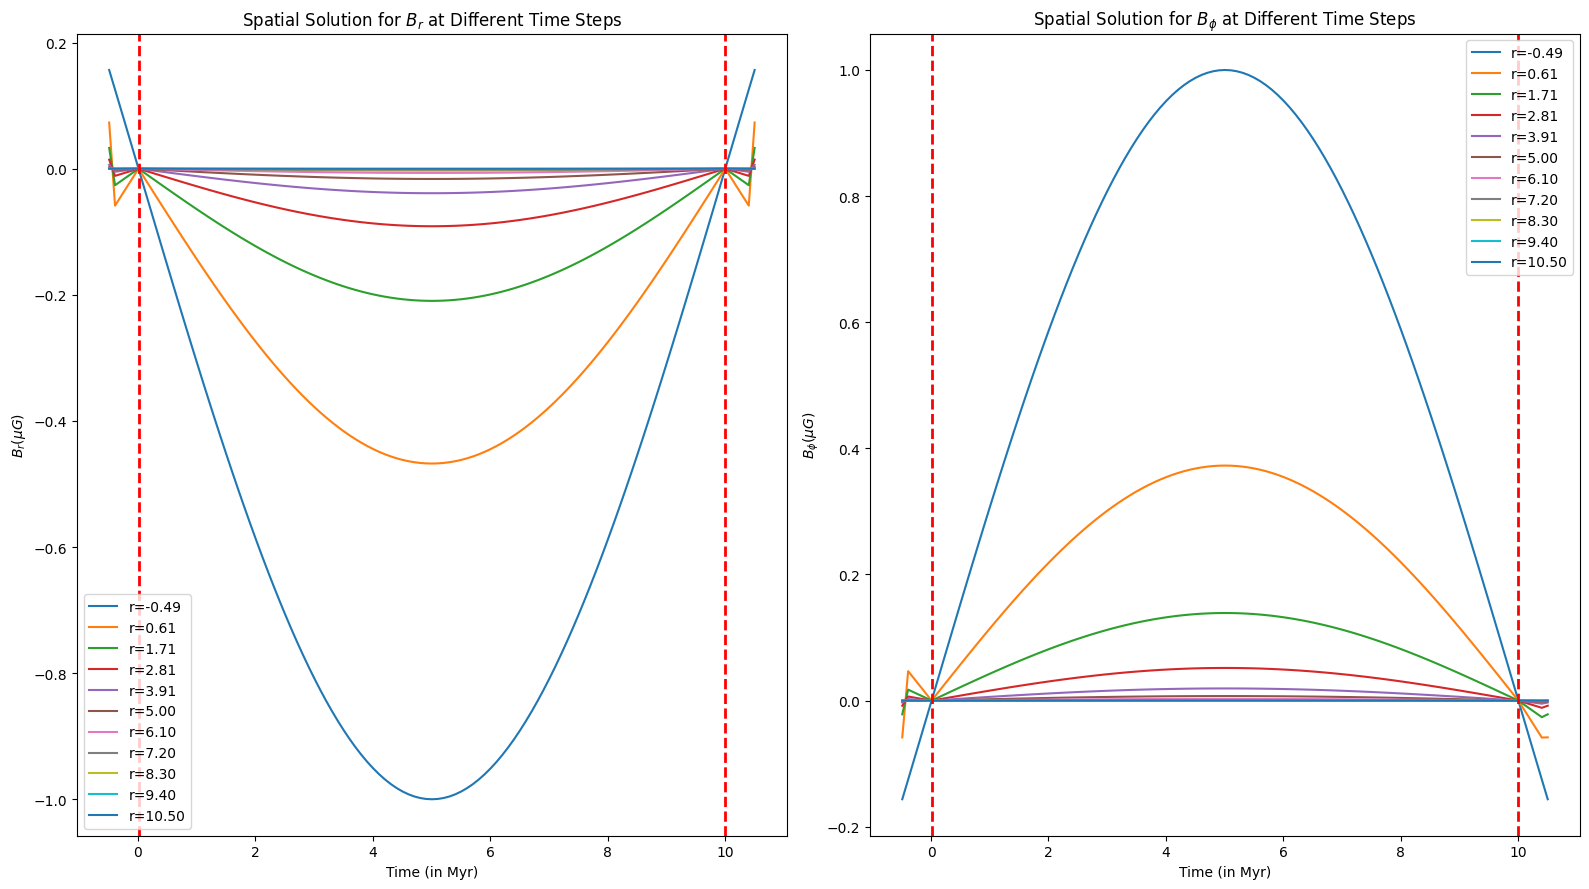

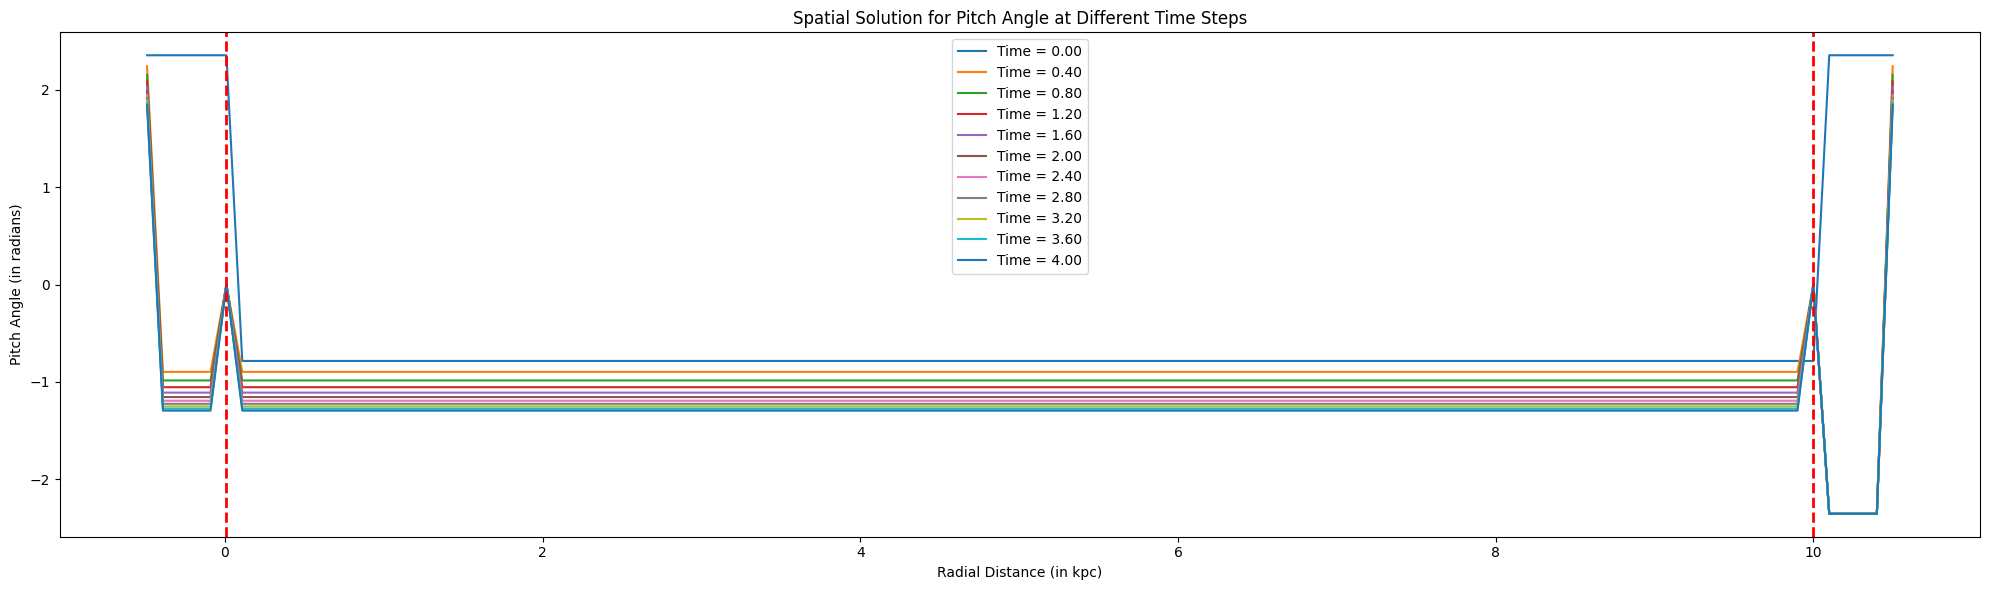

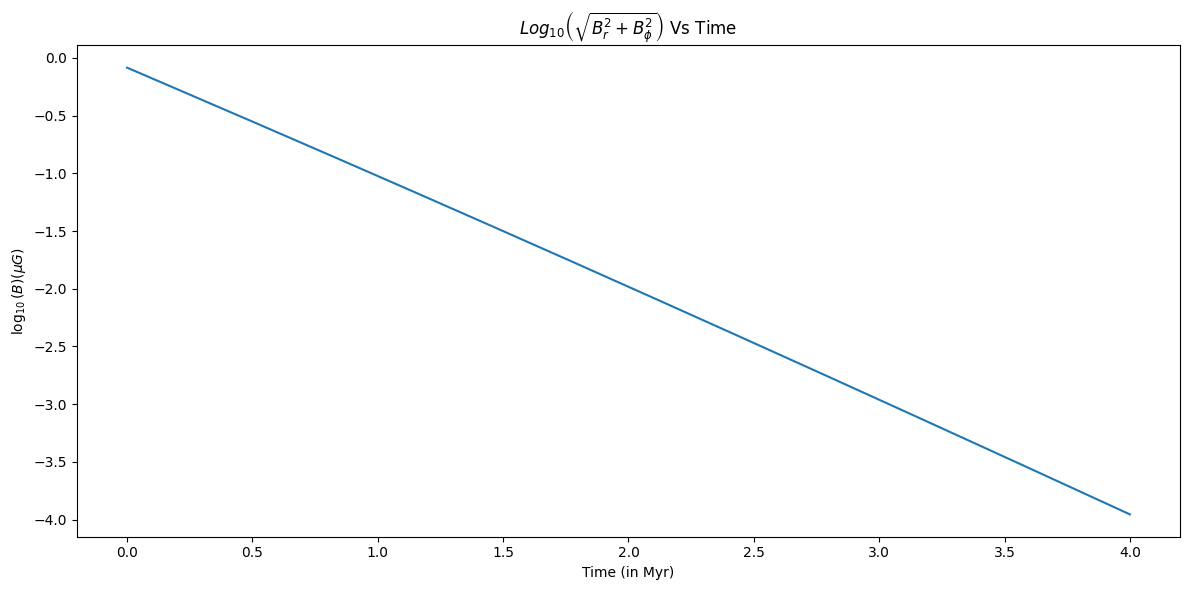

For alpha value= 10 



Dynamo Number = -93.89966583068129


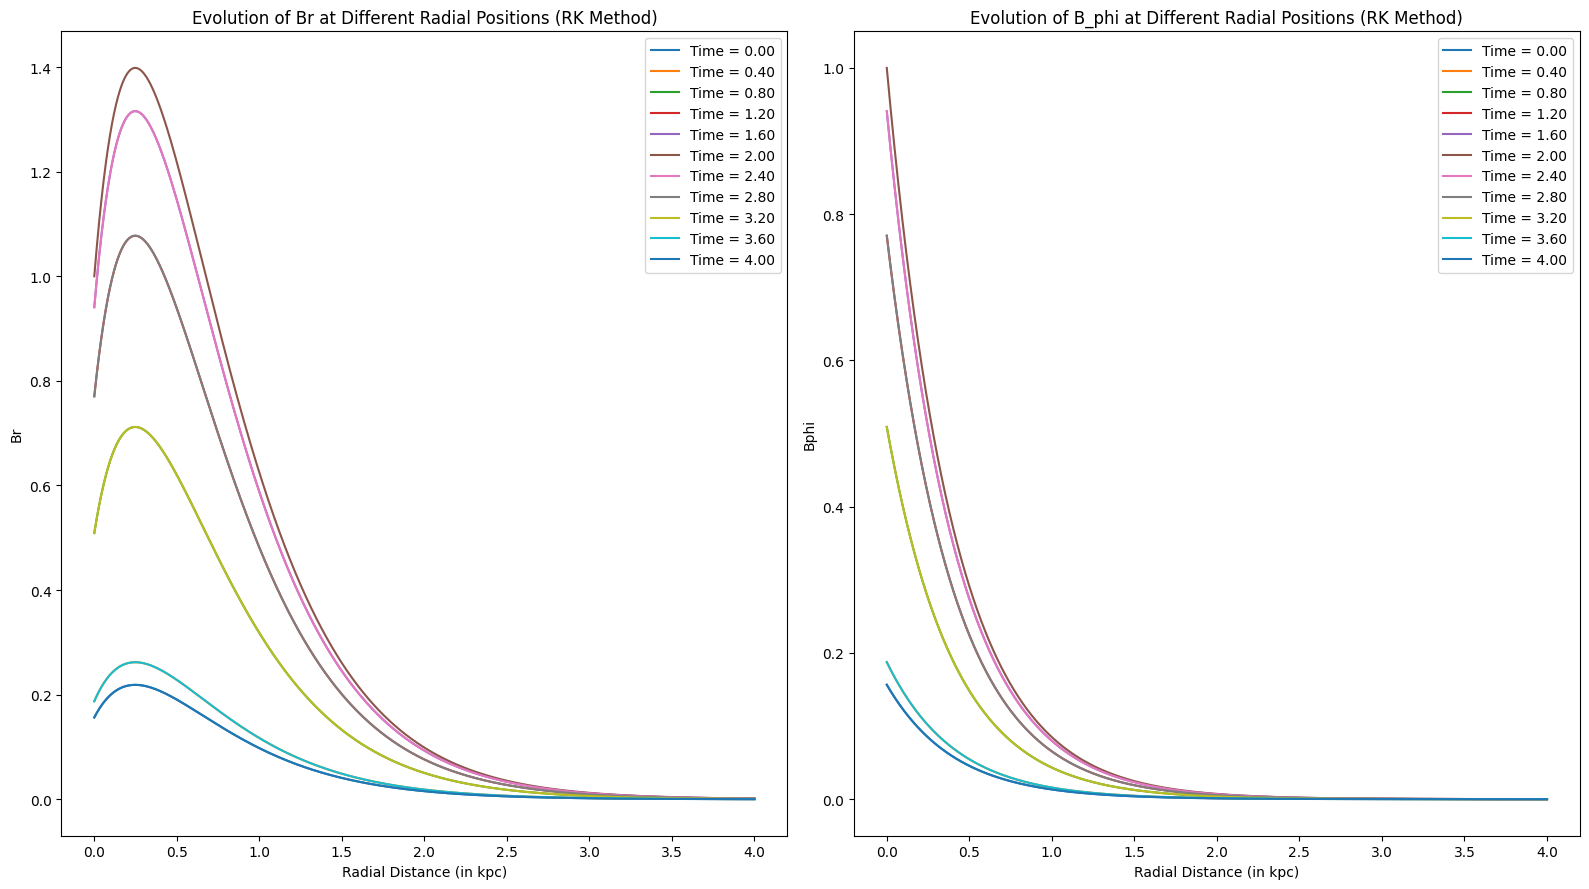

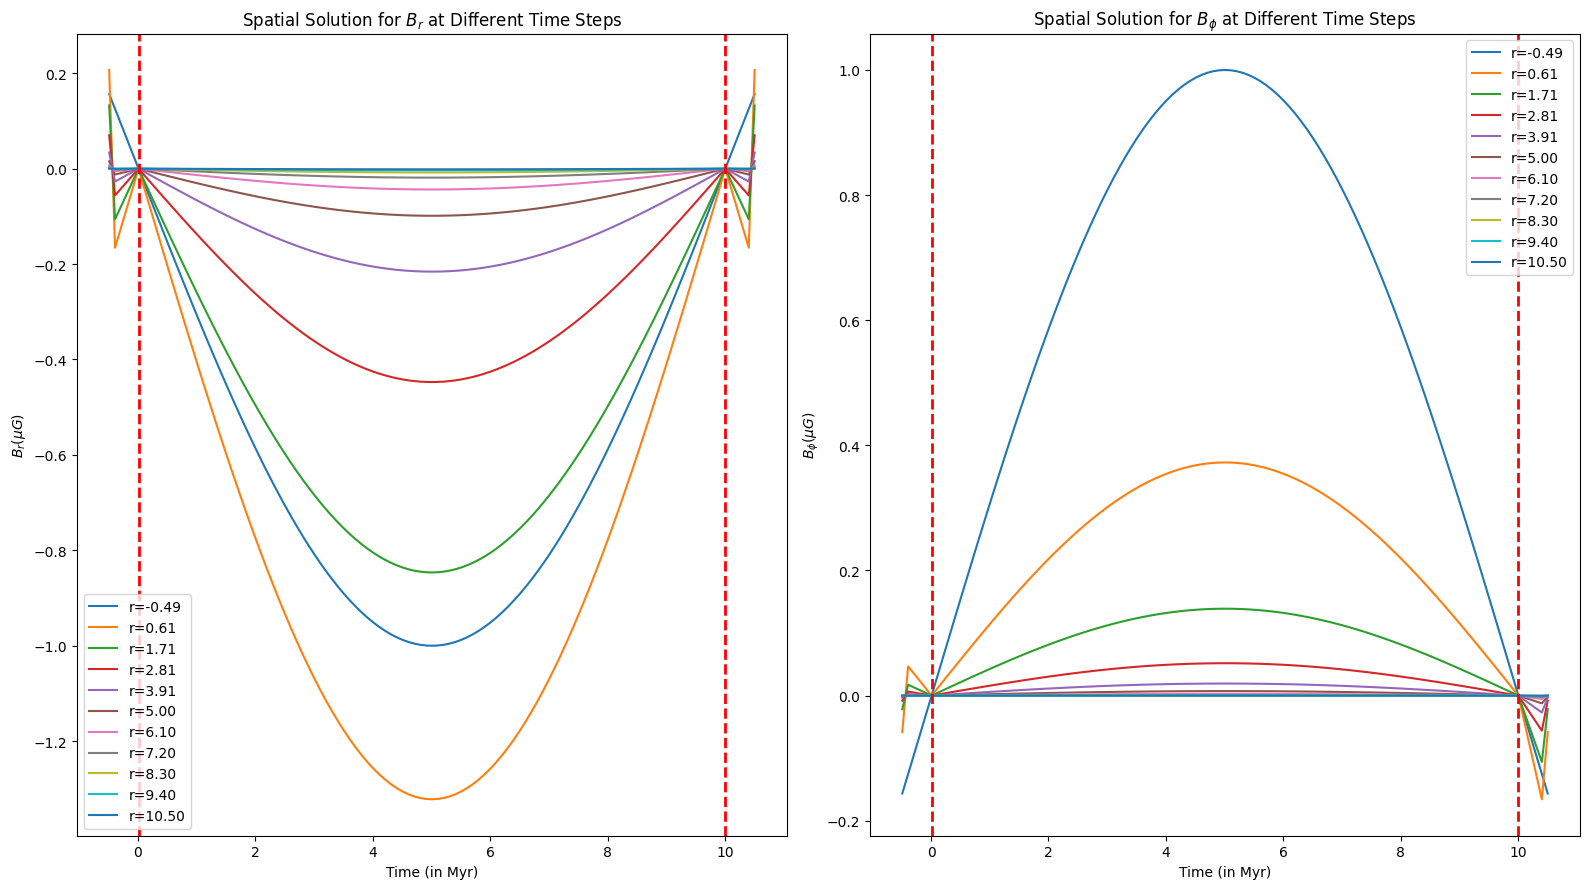

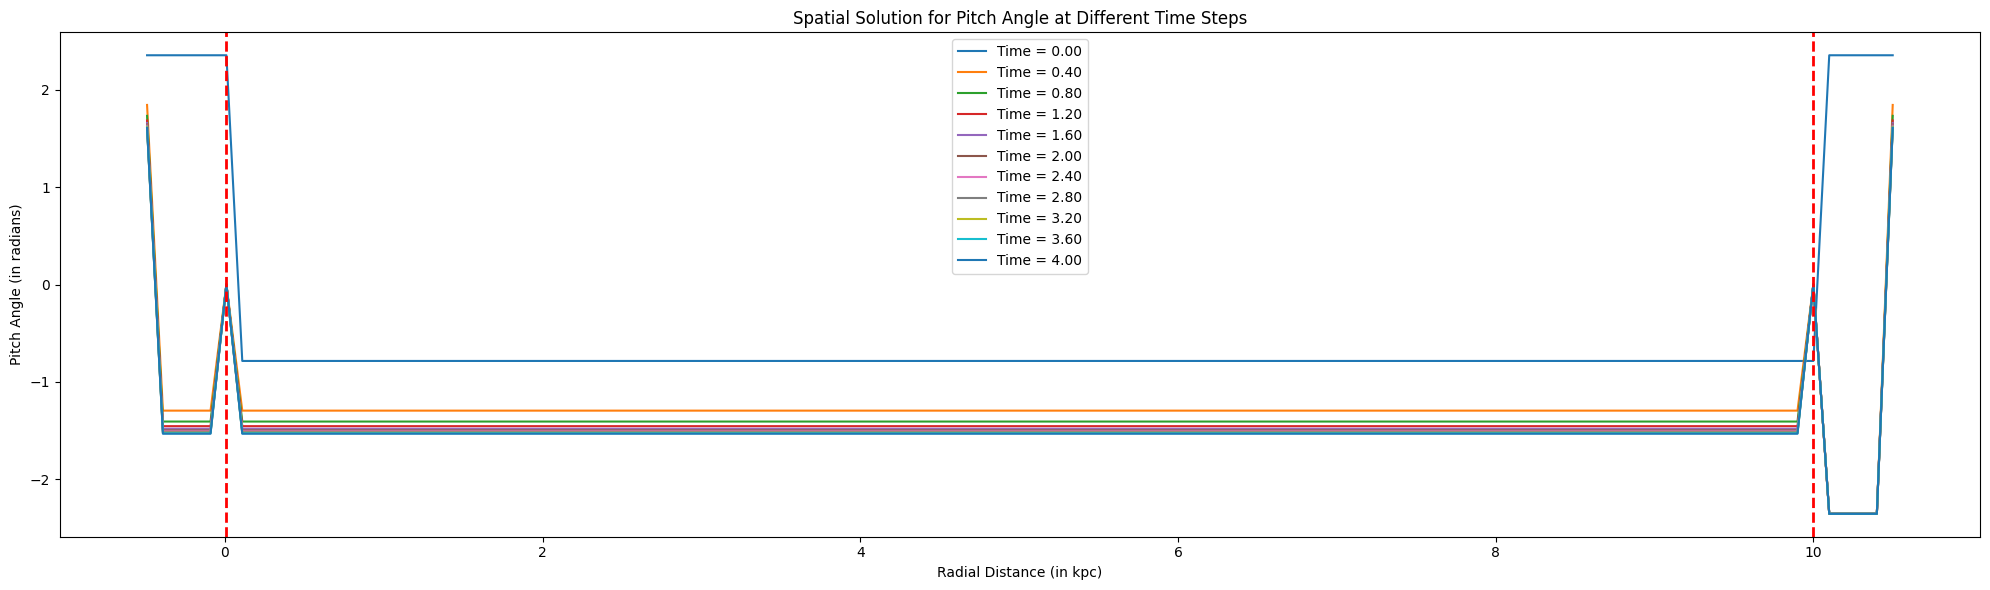

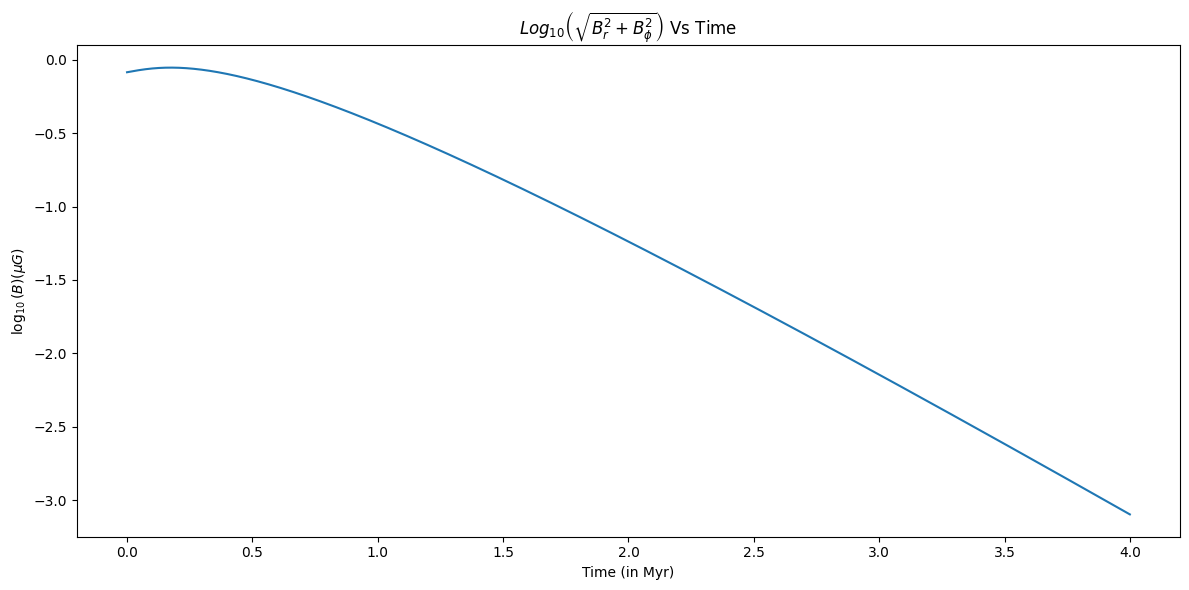

For alpha value= 100 



Dynamo Number = -938.9966583068131


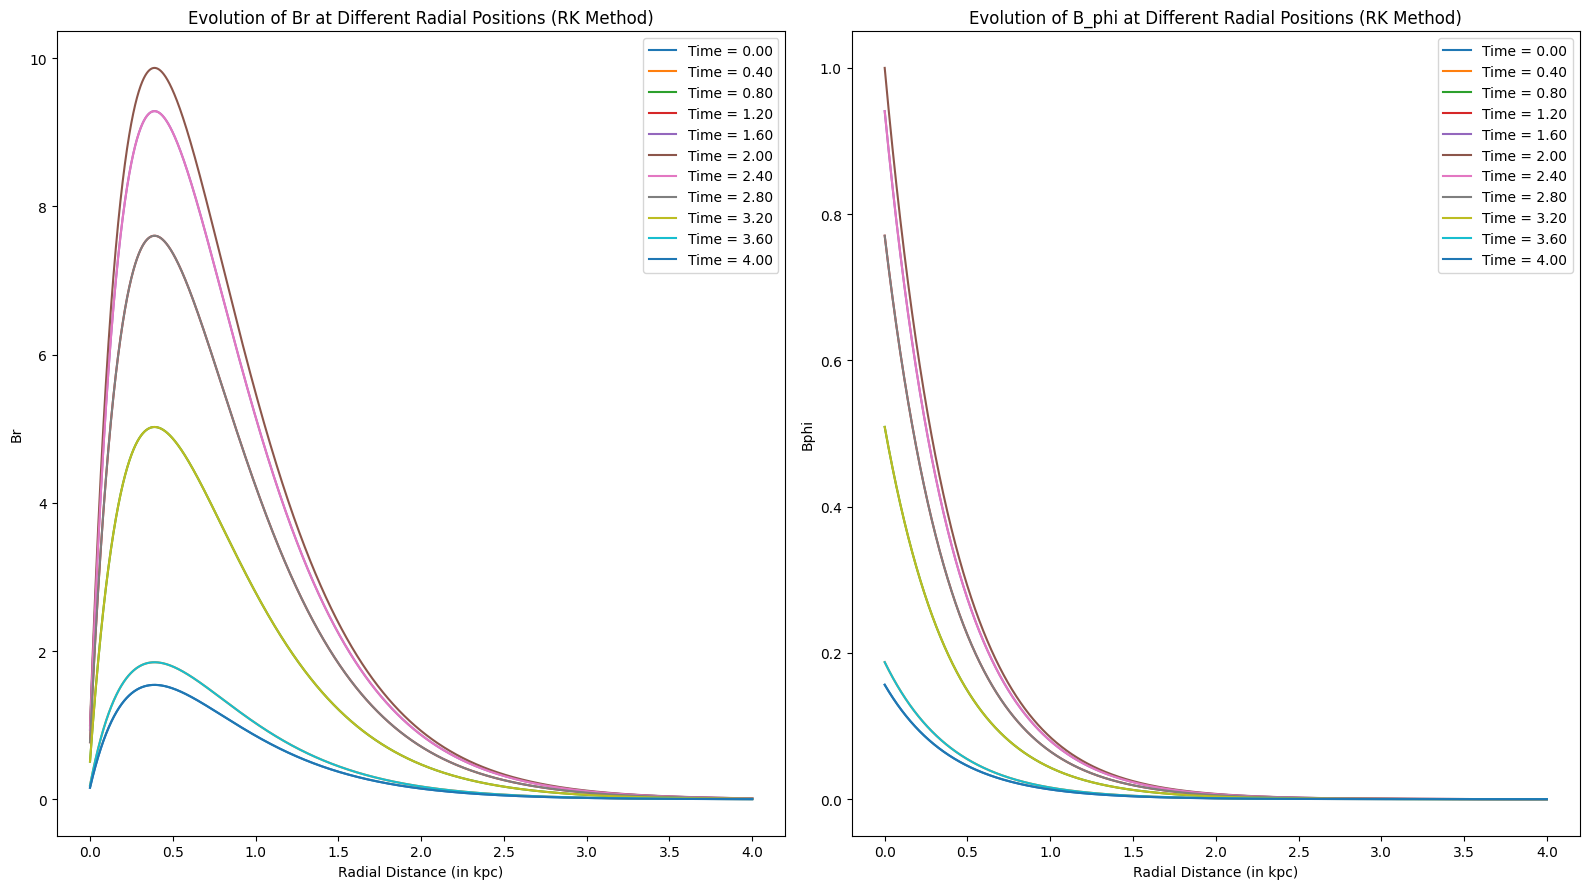

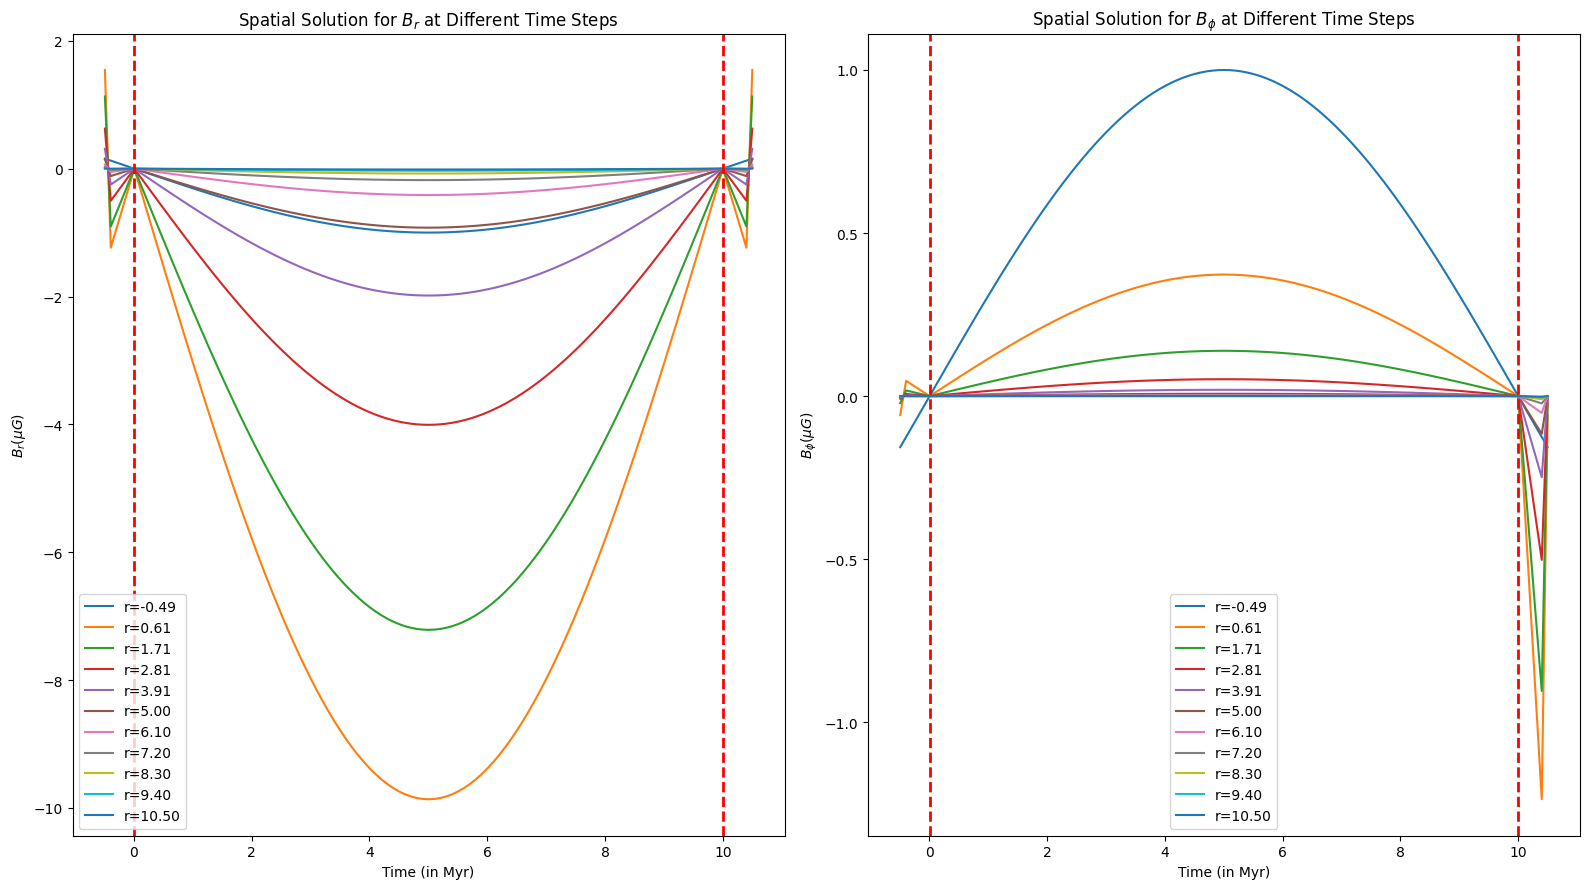

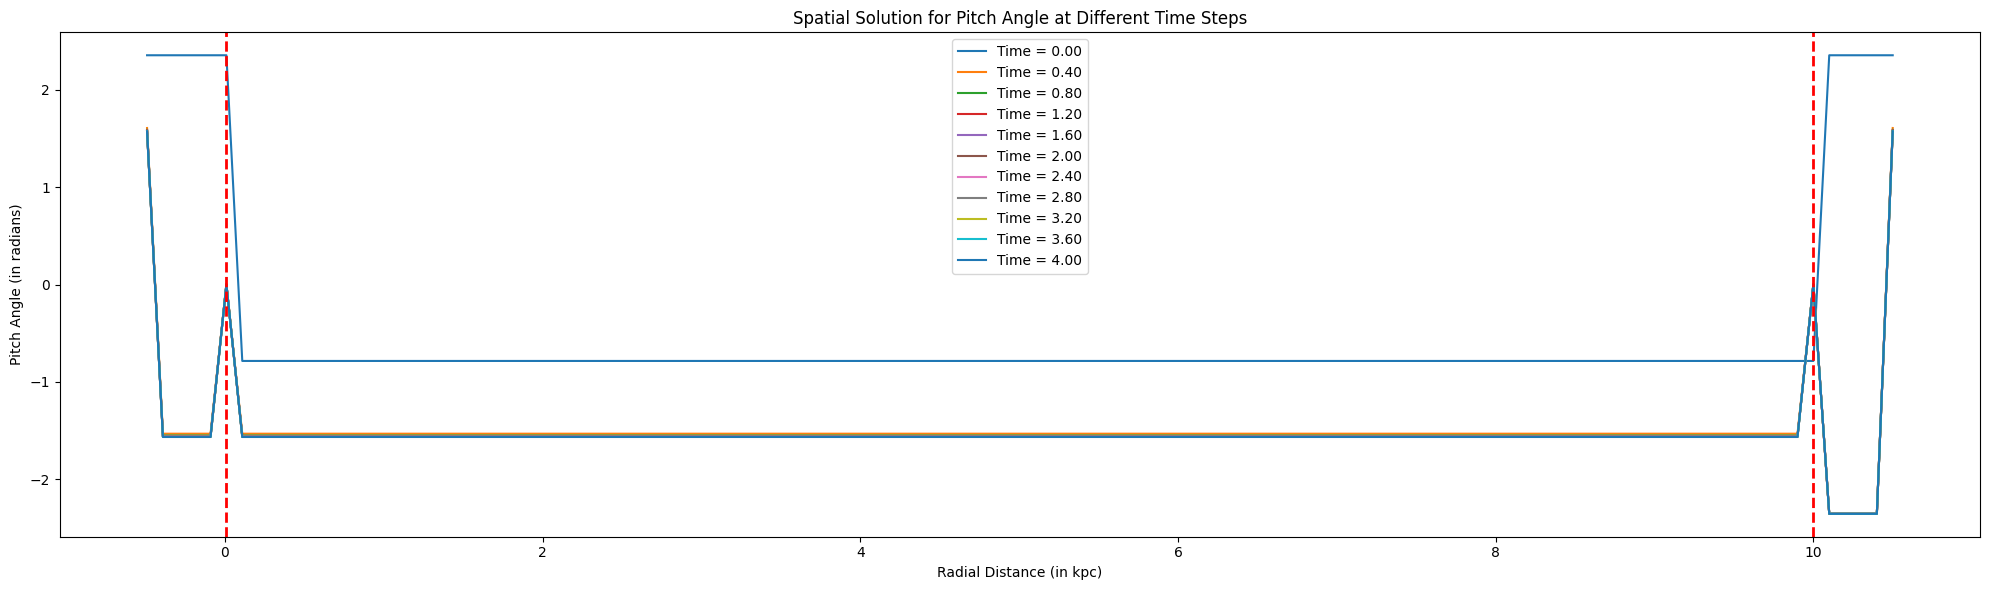

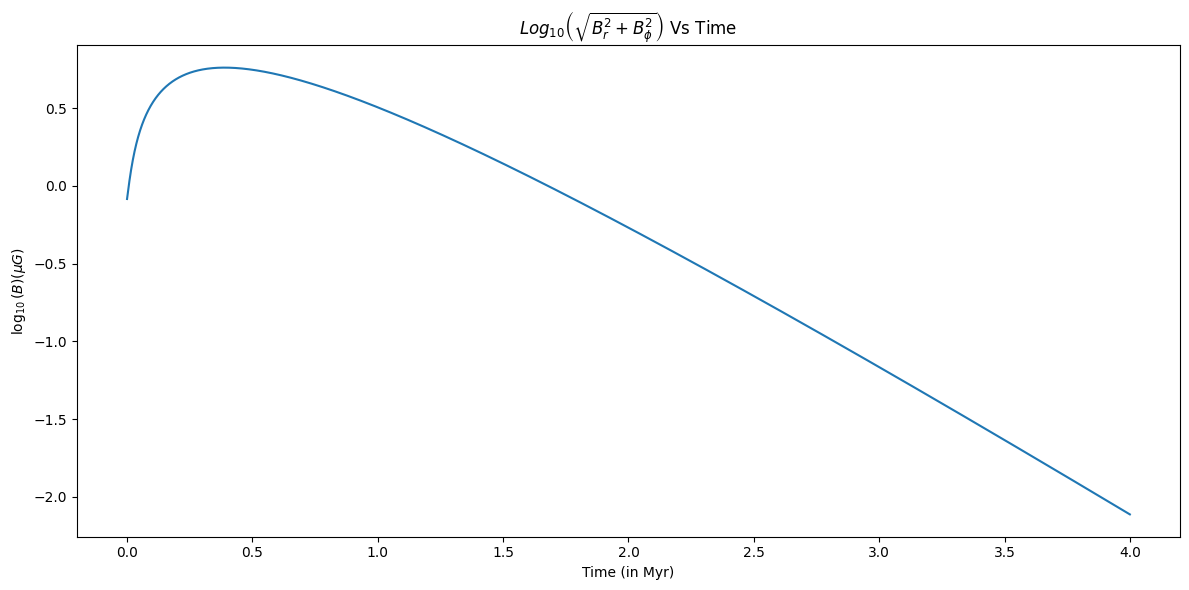

For alpha value= 500 



Dynamo Number = -4694.983291534066


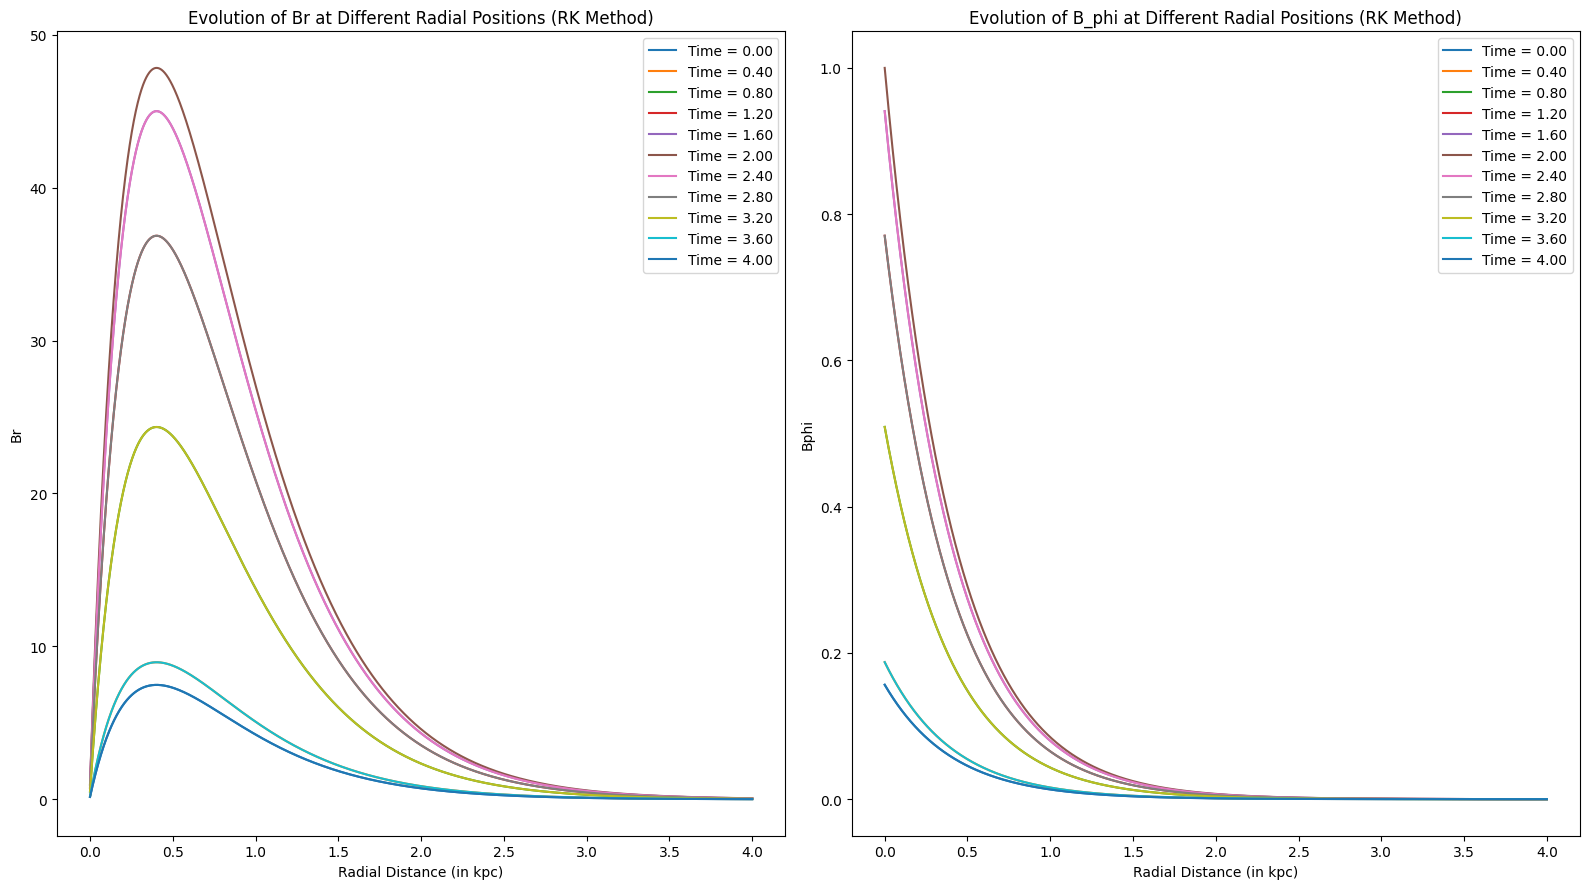

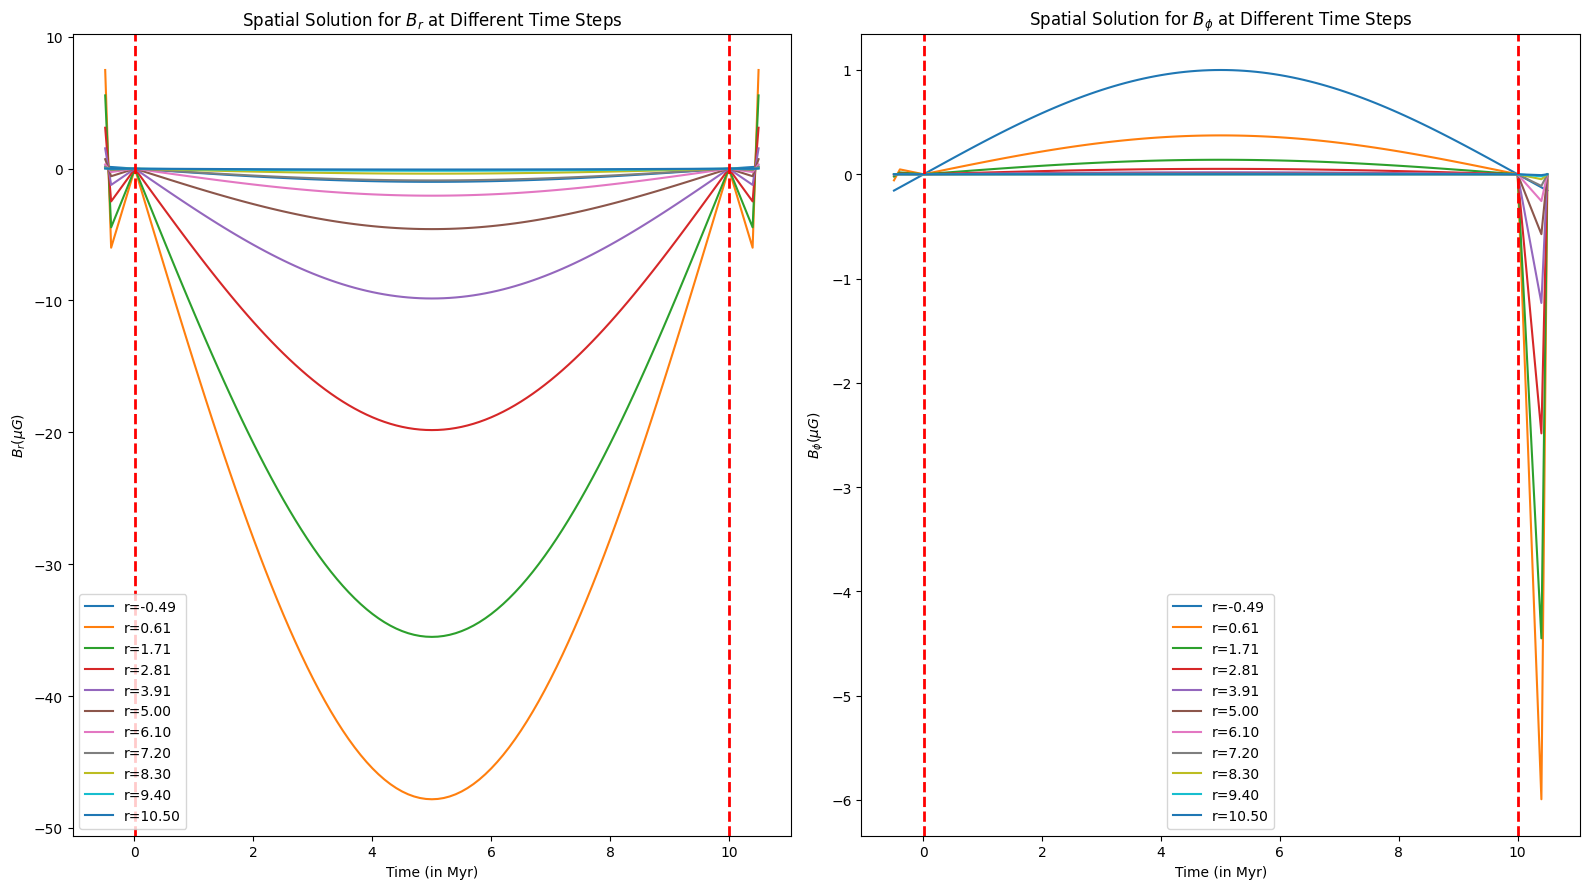

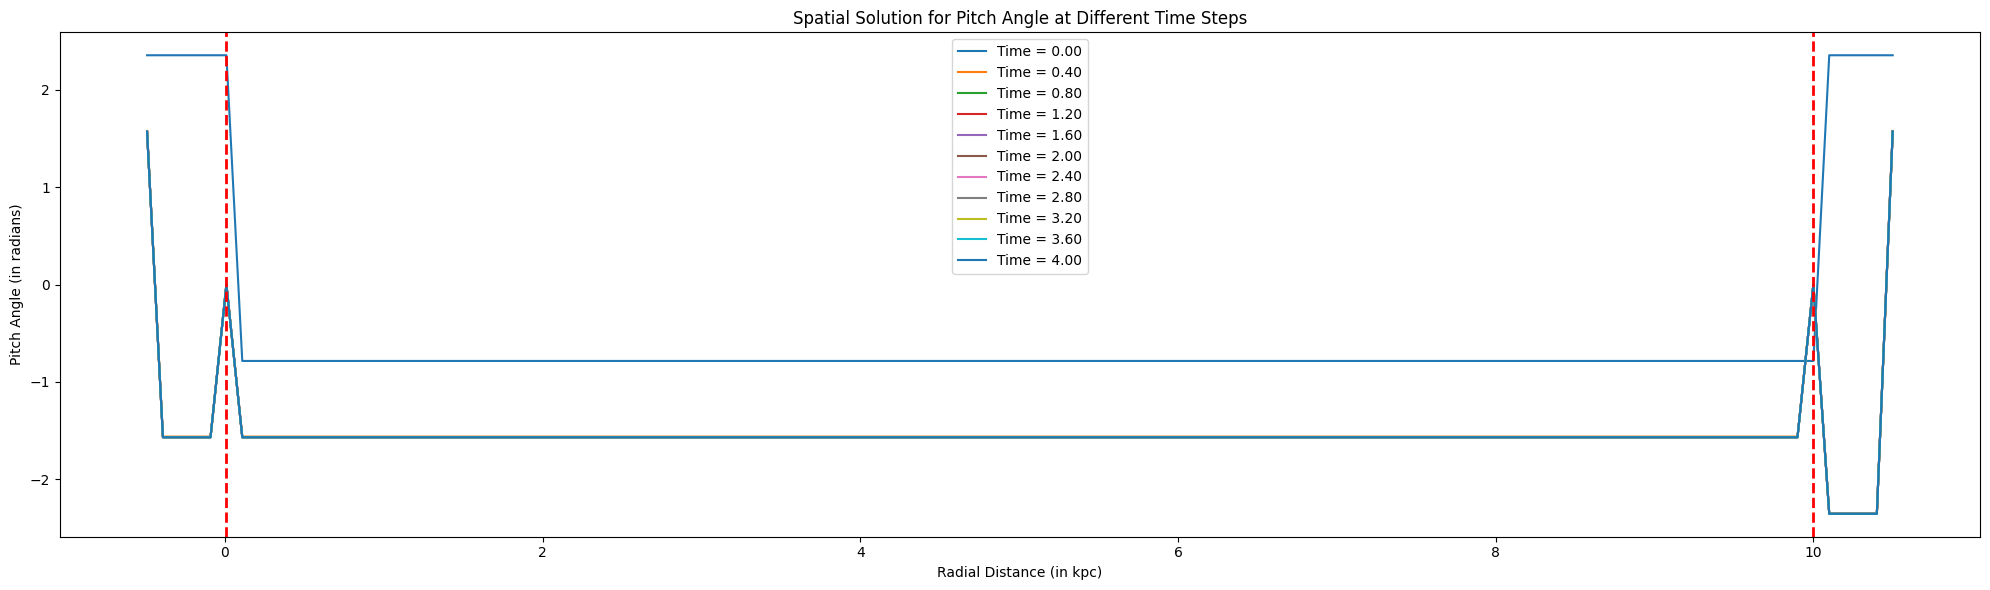

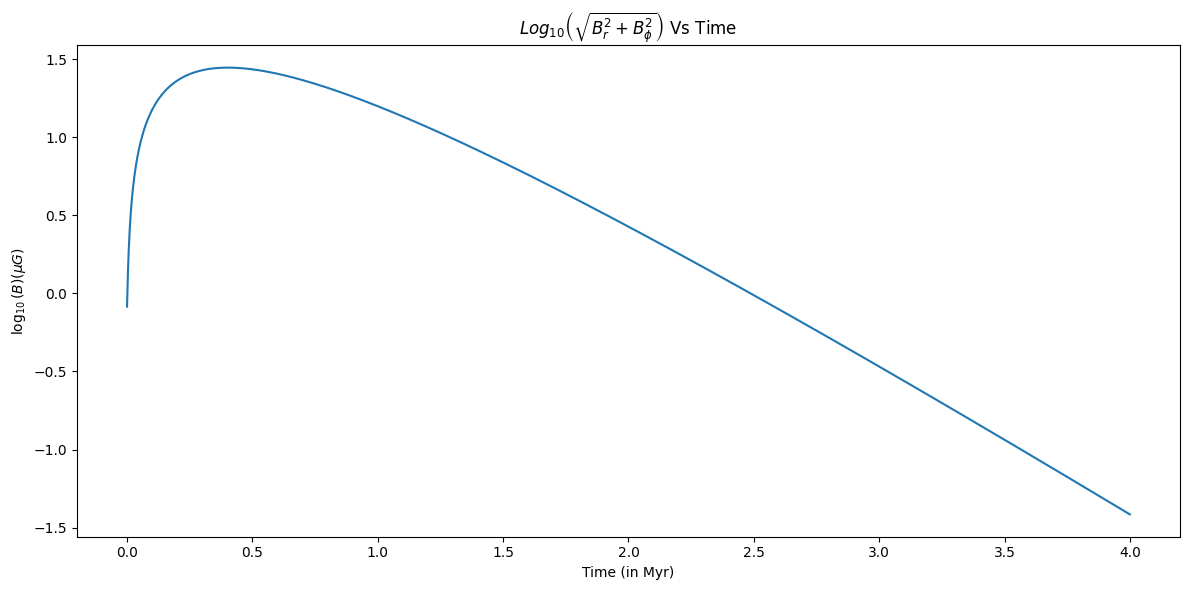

For alpha value= 1000 



Dynamo Number = -9389.966583068132


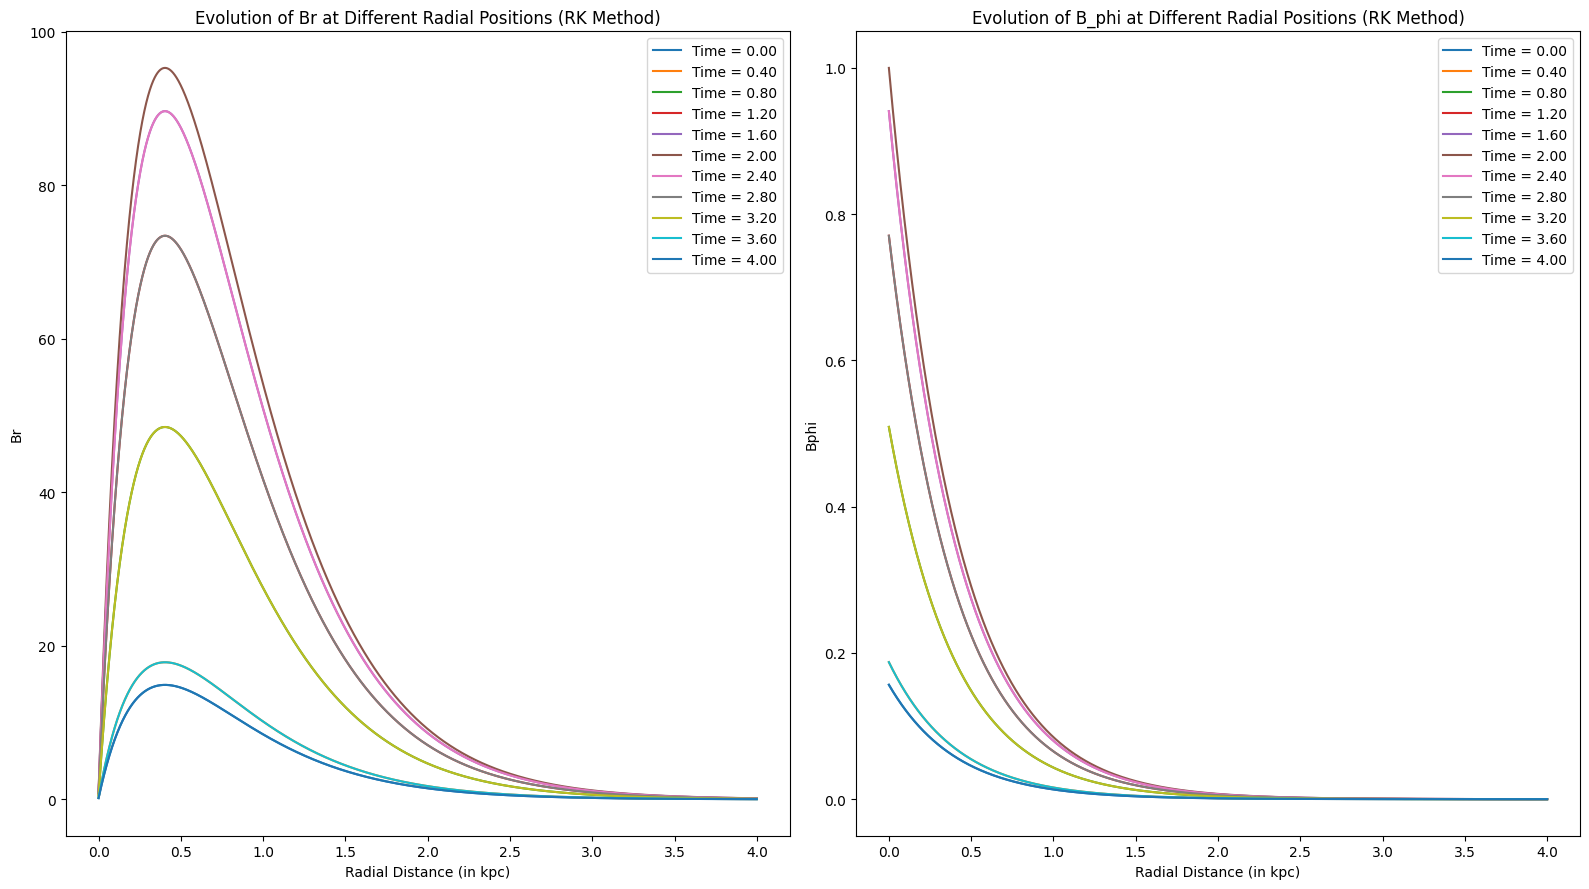

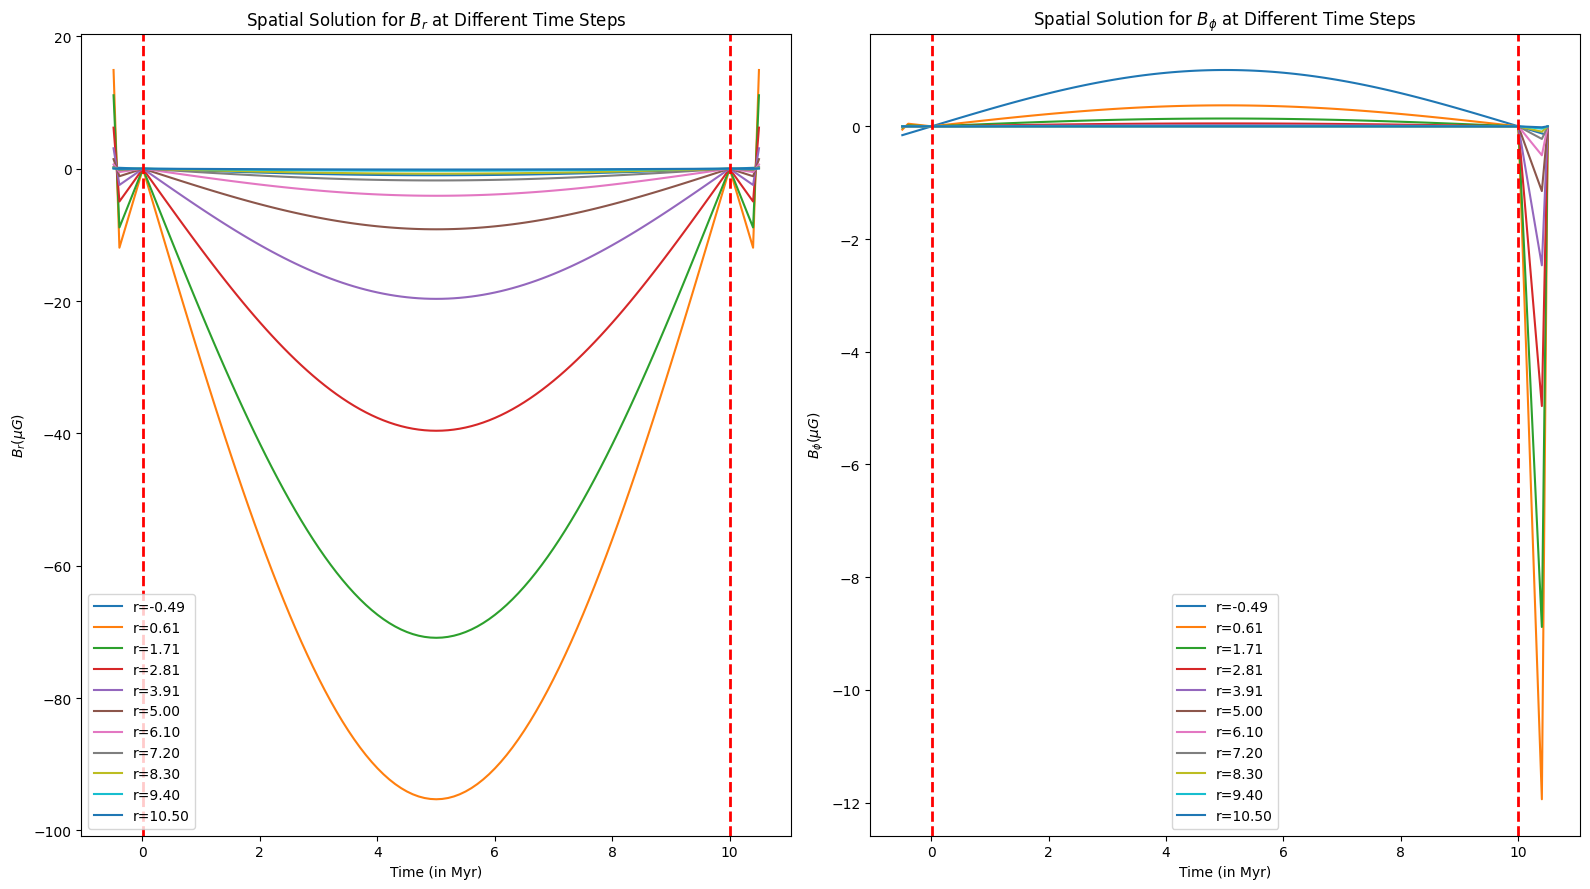

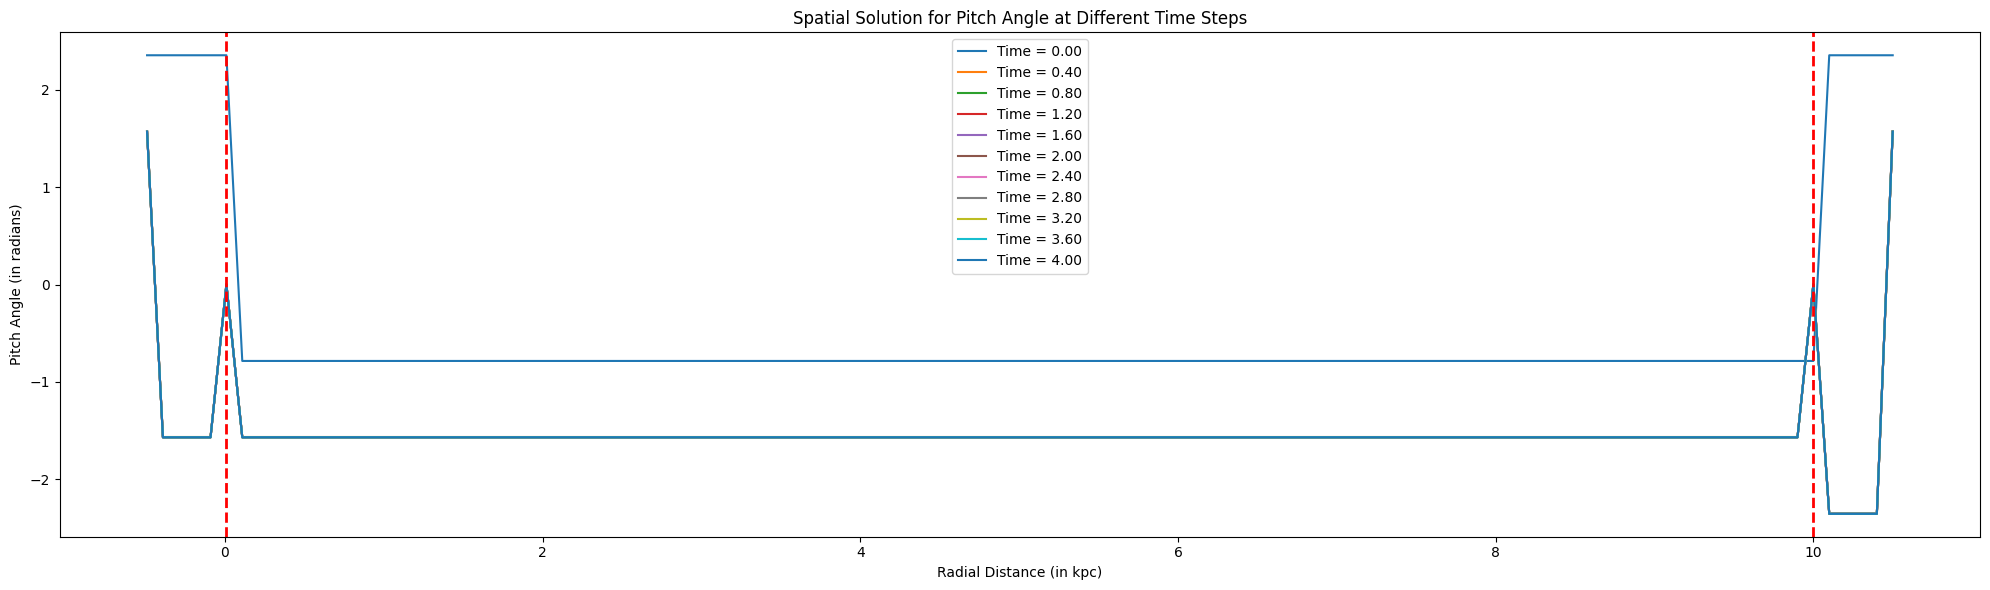

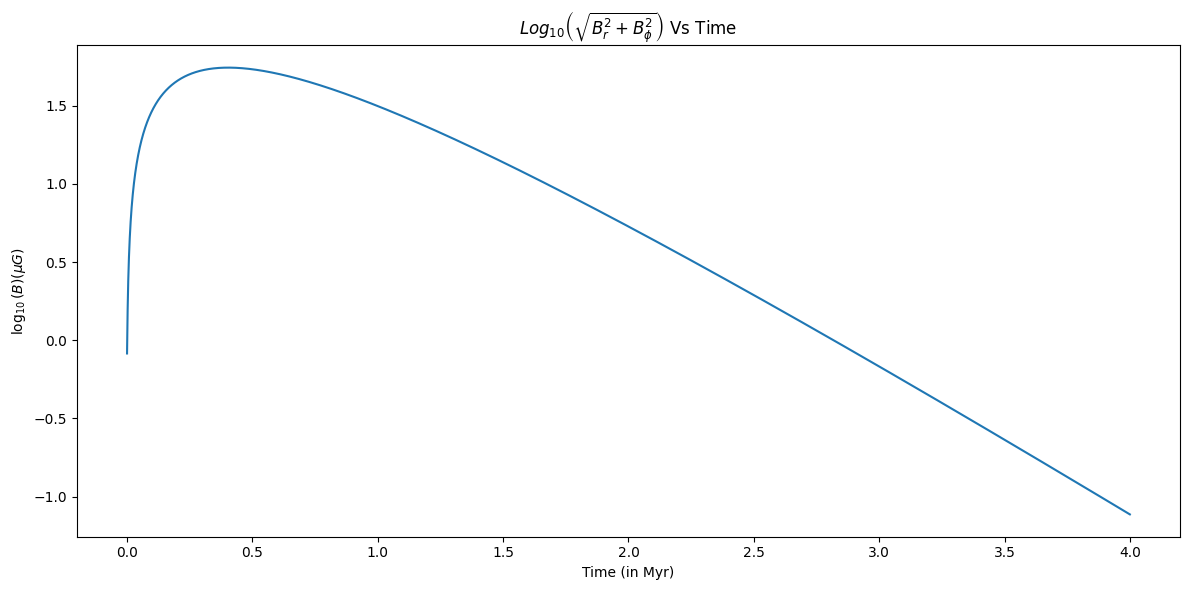

For alpha value= 10000 



Dynamo Number = -93899.6658306813


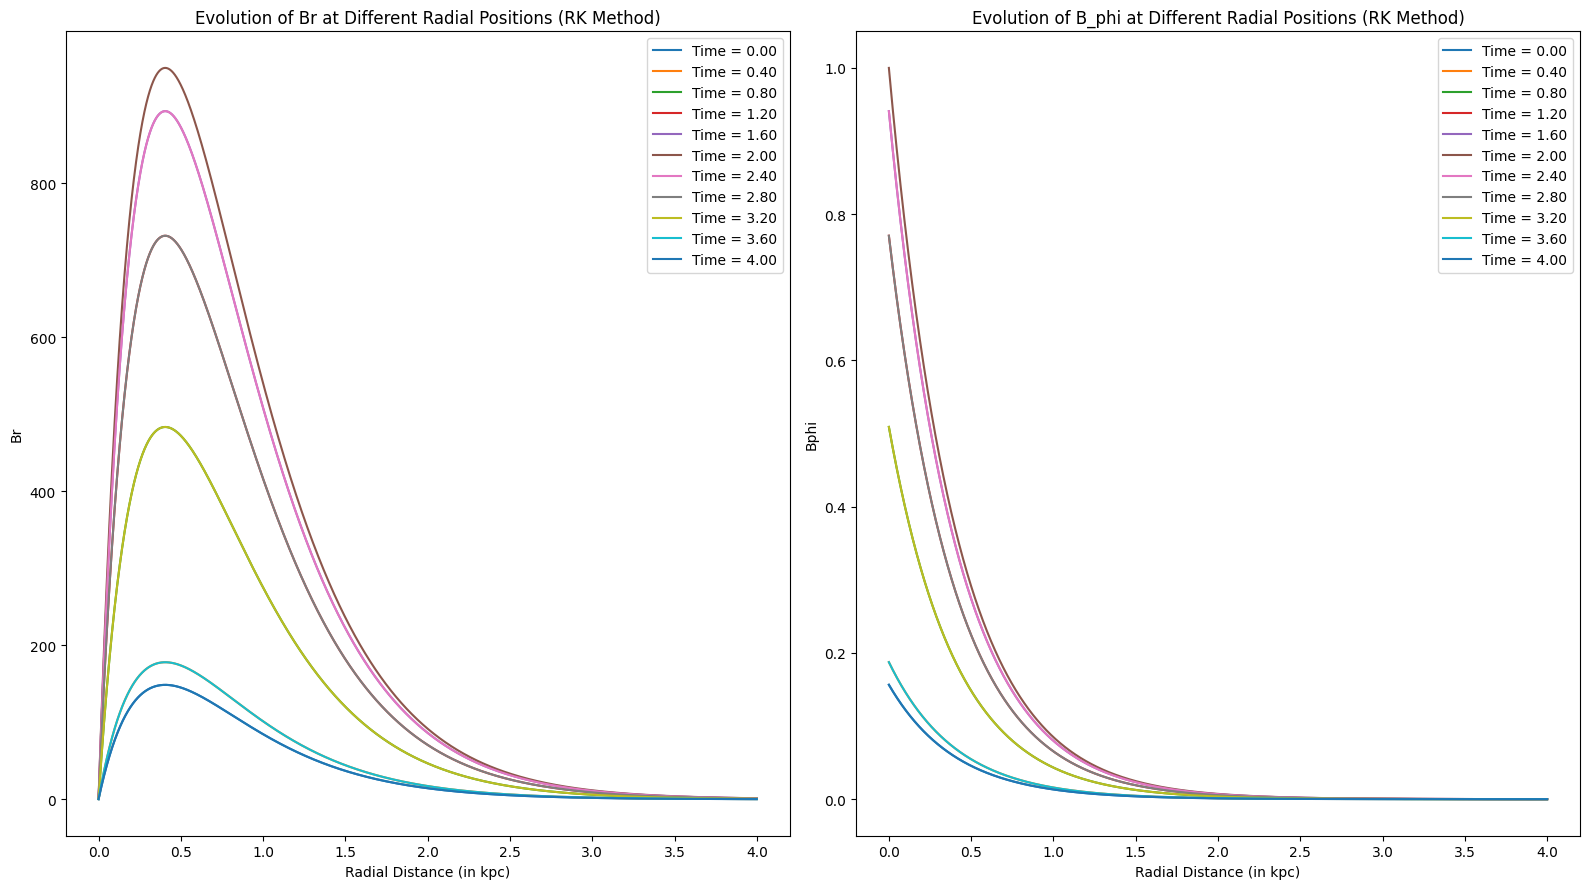

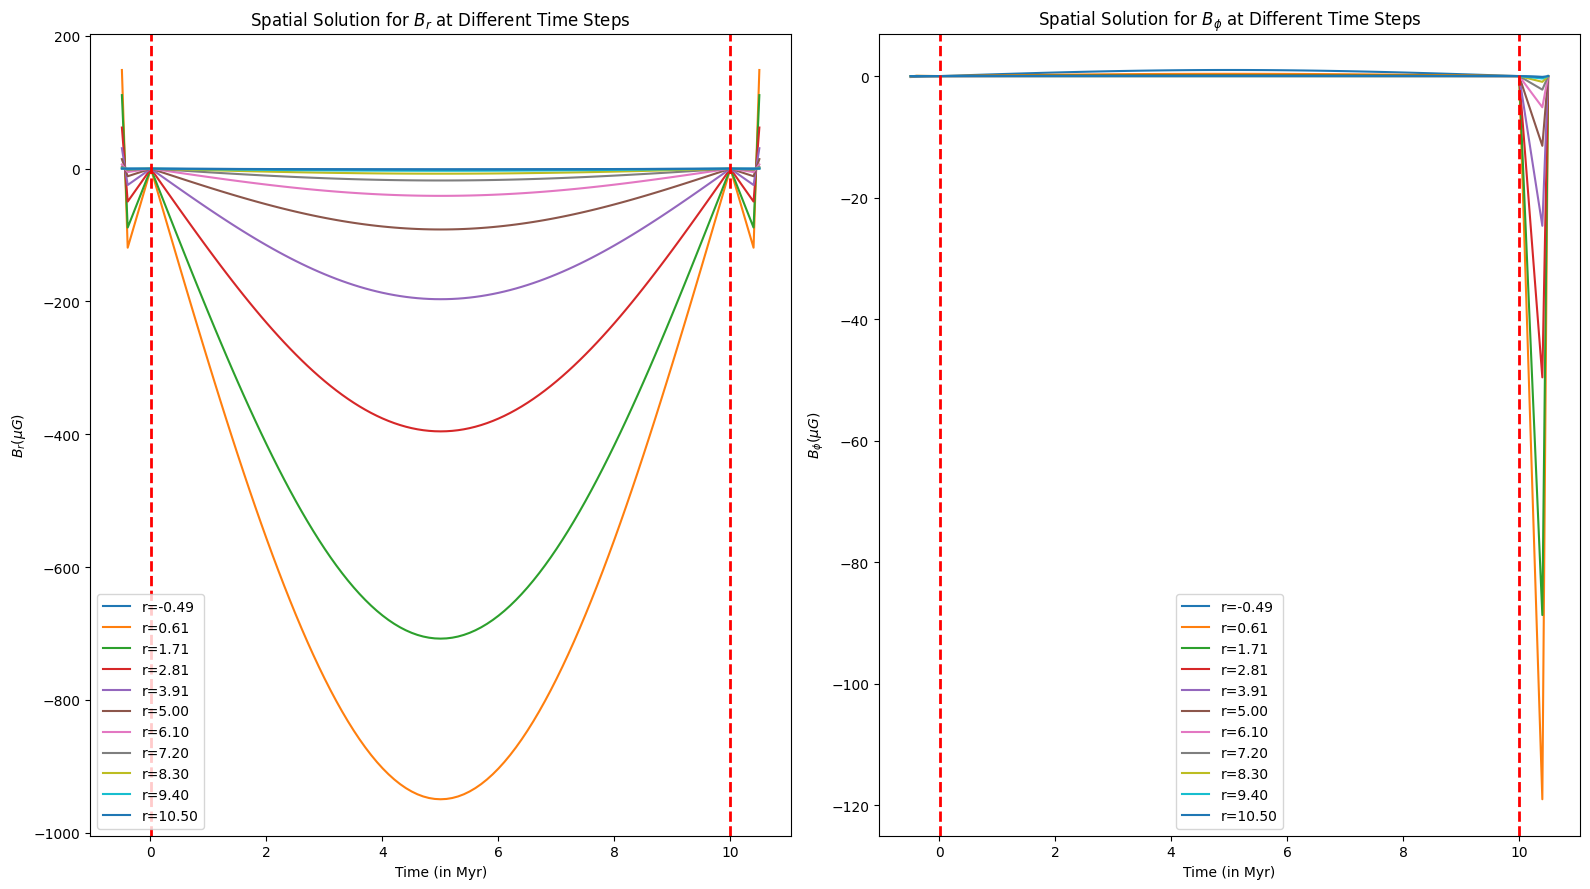

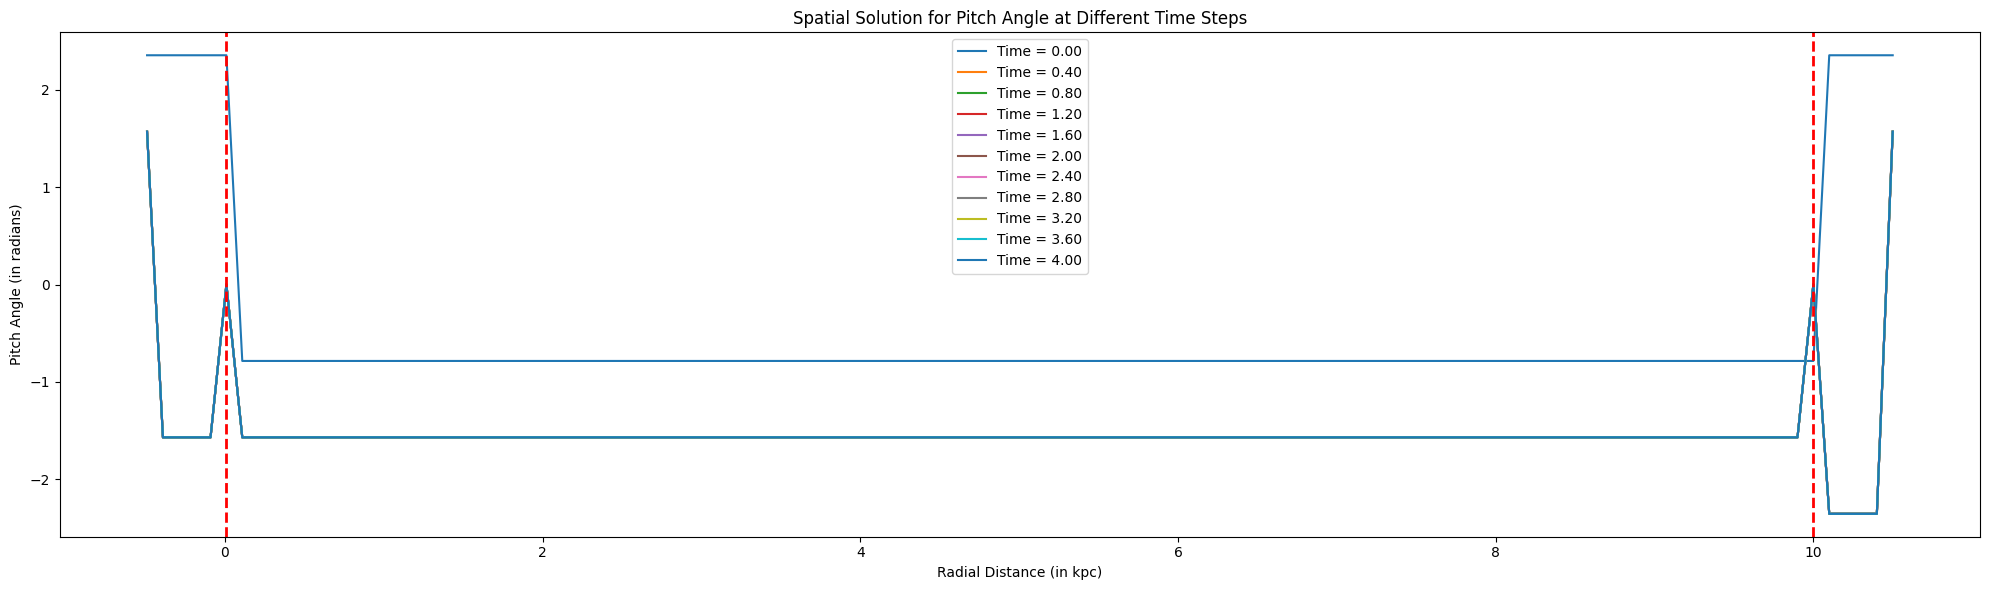

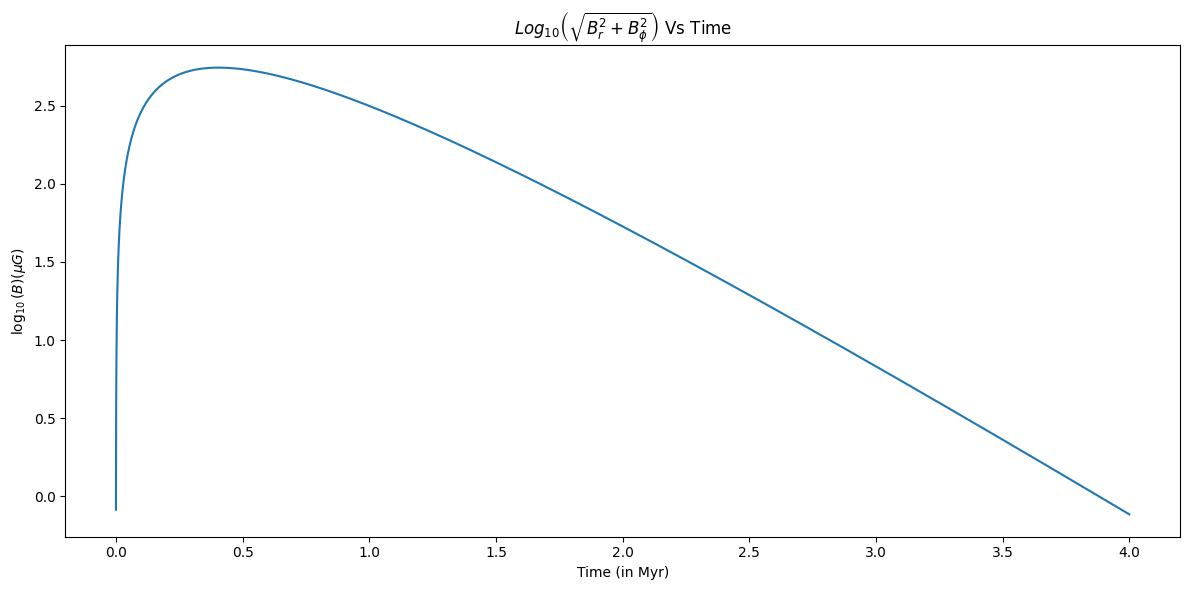

For alpha value= 50000 



Dynamo Number = -469498.3291534064


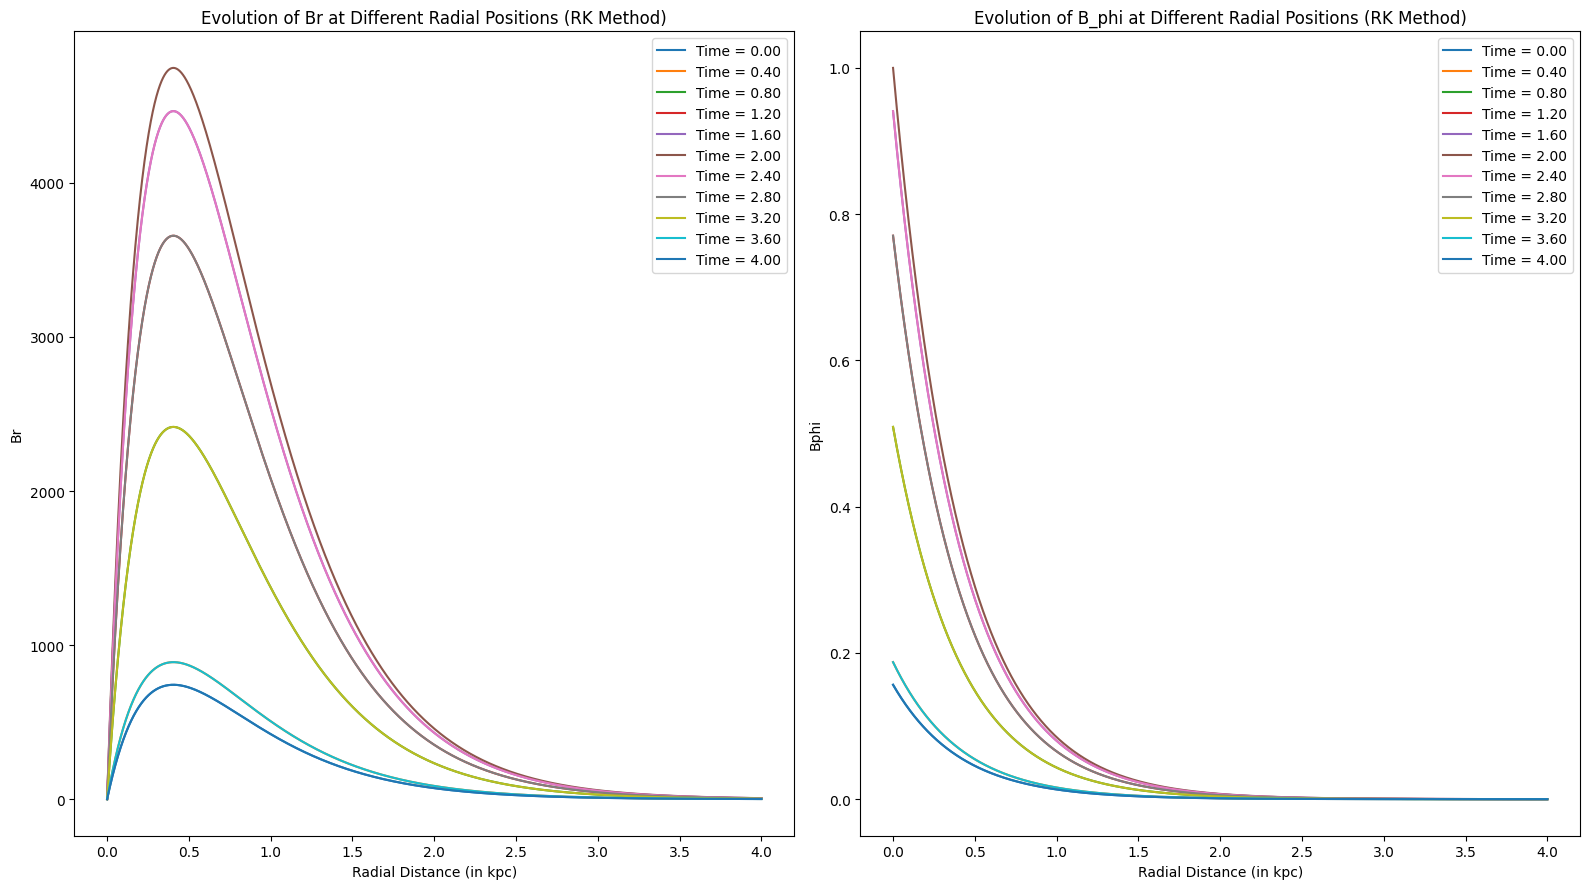

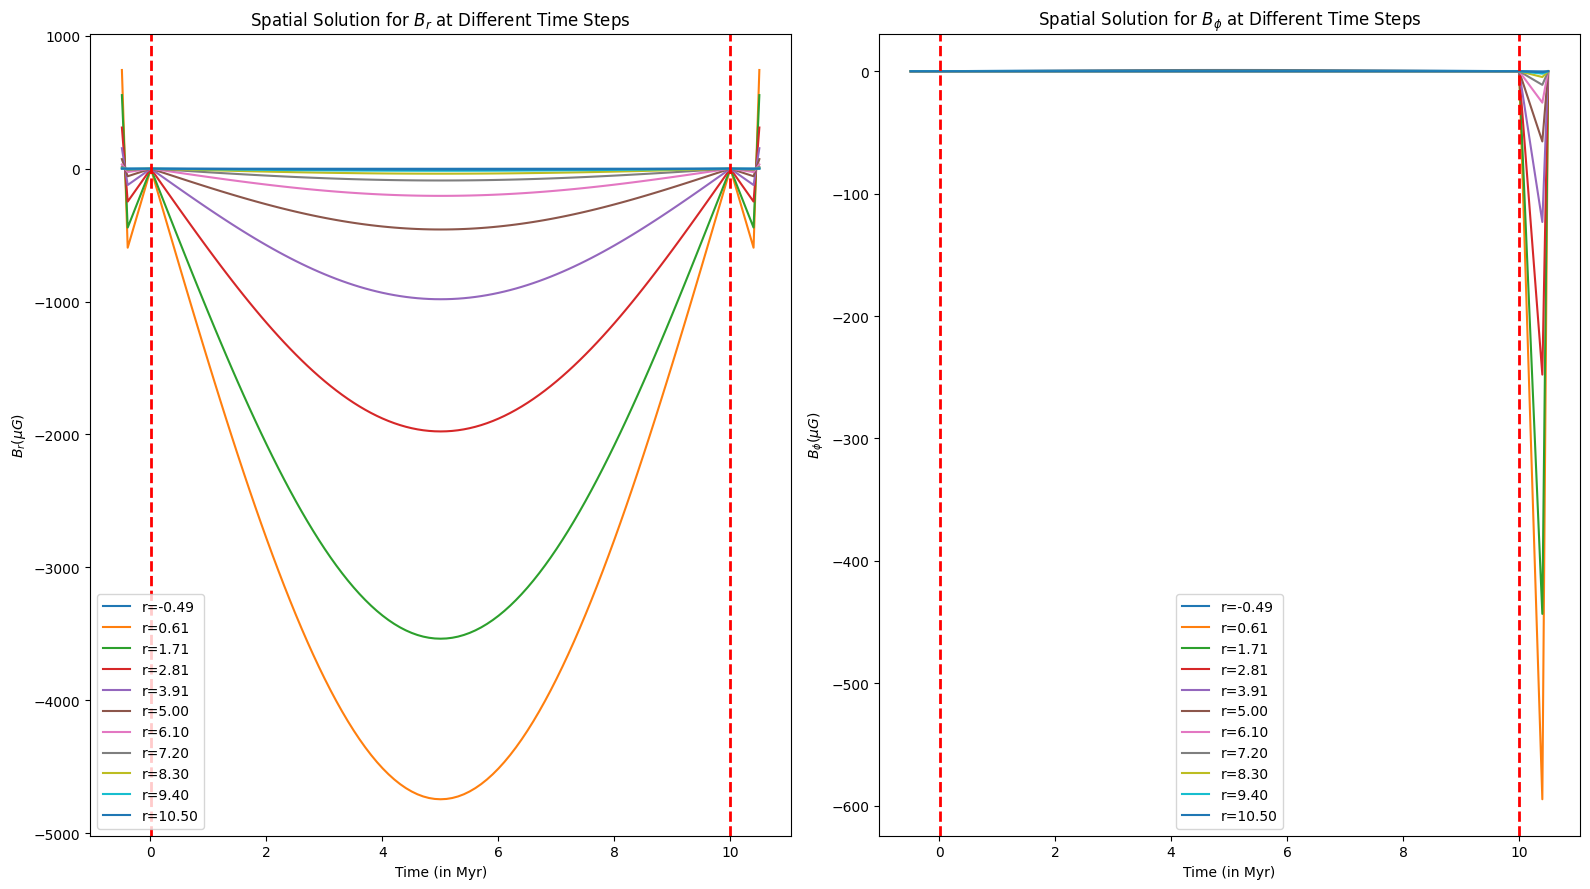

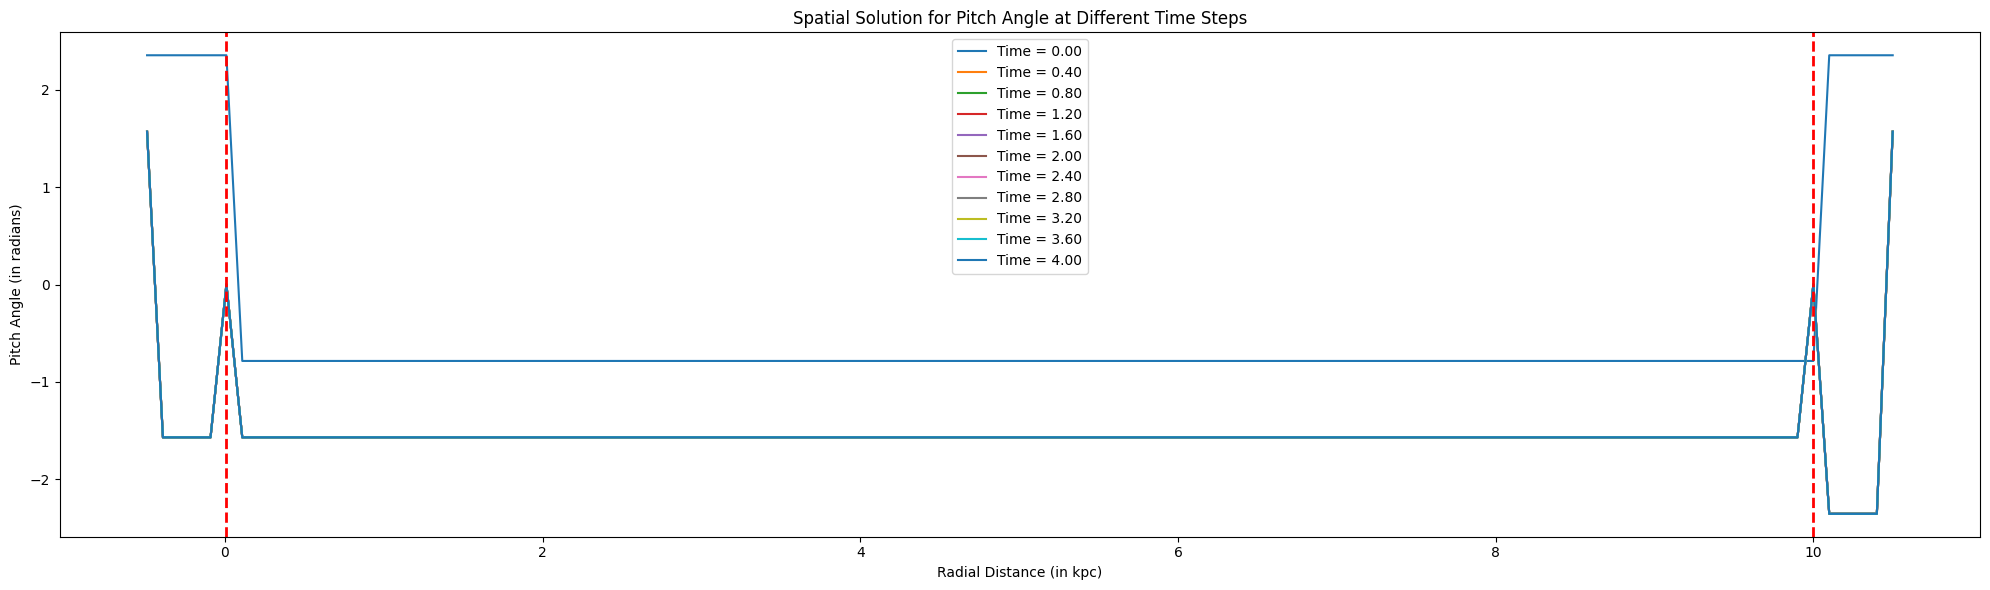

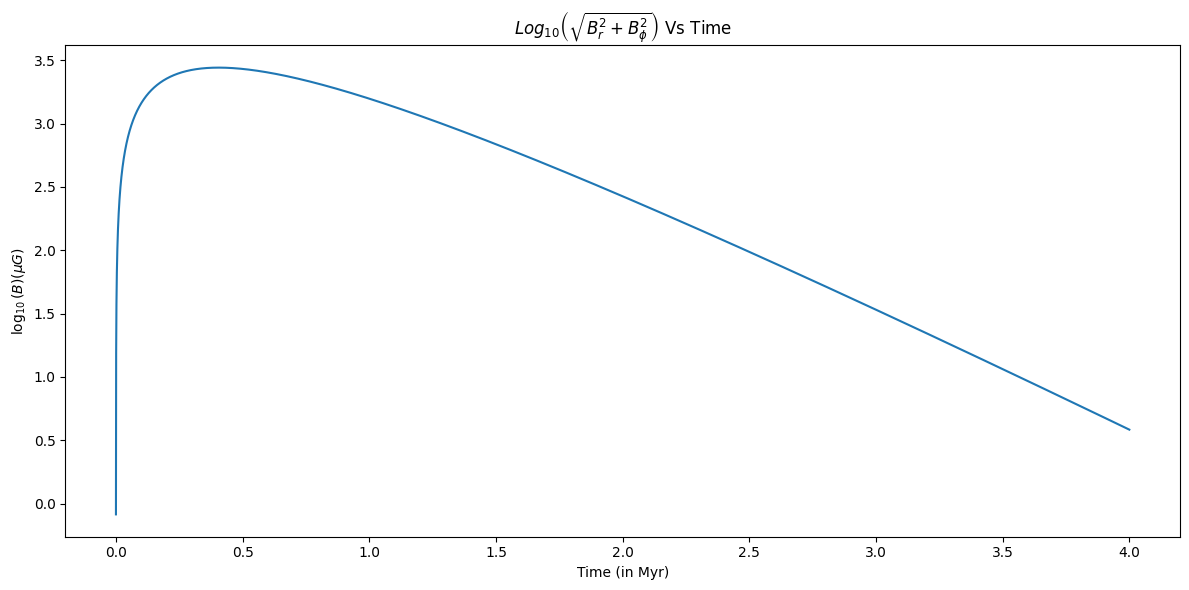

In [11]:
# Define the alpha
alpha = [1,10,100,500,1000,10000, 50000]

# Plotting the initial magnetic fields
plt.ioff()
InitialPlot()
plt.ion()
for i in alpha:
    print('For alpha value=',i,'\n\n\n')
    Br_t = np.zeros((Nt + 1, Nr))
    Bphi_t = np.zeros((Nt + 1, Nr))
    Br=Br_Orig
    Bphi=Bphi_Orig
    for t in range(Nt + 1):
        Br_t[t, :] = np.copy(Br)
        Bphi_t[t, :] = np.copy(Bphi)
        Br,Bphi= rk4_step(Br,Bphi,i)

    #Dynamo Number
    DynamoNumber(i)
    
    #Plotting the evolution of Br and Bphi against time for different radial distance.
    MagVsTime(Br_t,Bphi_t)

    #Plotting the evolution of Br and Bphi against different radial distance for a given time
    MagVsRadial(Br_t,Bphi_t)    
    
    #Defining the pitch
    Pitch(Br_t,Bphi_t)
    
    #Plotting Log B Vs Time to obtain the global gamma value
    LogB_T(Br_t,Bphi_t)


#finding Dc
# Req= Gamma(np.linspace(2.5,5,10))
# print('The Crtical Dynamo number is', Req,'r * dΩ/dr$')


In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML, display


# x_value = r_values
# y_vlues = Br_t
# plots = []
# times = []

# x_lim = (r_min,r_max)
# y_lim = (-10000,10)

# for t in range(0, Nt + 1, Nt // 10):
#     plt.ioff()
#     plt.figure(figsize=(16, 9))
#     plt.xlim(x_lim)
#     plt.ylim(y_lim)
#     plot, = plt.plot(r_values, Br_t[t, :], label=f'Time = {t * dt:.2f}')
#     plt.clf()
    
    
#     times.append(t * dt)
#     plots.append(plot)
#     plt.xlabel('Radial Distance (kpc)')
#     plt.ylabel(r'$B_r$')
#     plt.title(r'Spatial Solution for $B_r$ at Different Time Steps')
#     plt.legend()
#     plt.tight_layout()
#     #plt.figure()
#     plt.ion()
    

# # Define the animation function
# def animate(frame):
#     # Clear the current figure
#     plt.clf()    
#     # Plot the plot object corresponding to the current frame
#     plot = plots[frame]
#     plt.xlim(x_lim)
#     plt.ylim(y_lim)
#     plt.plot(plot.get_xdata(), plot.get_ydata(), label=f'Time = {times[frame]:.2f}')  # Plot the selected plot
#     plt.xlabel('Radial Distance (kpc)')
#     plt.ylabel(r'$B_r$(T)')
#     plt.title(r'Spatial Solution for $B_r$ at Different Time Steps')
#     plt.legend()
#     plt.tight_layout()

#     return [plot]  # Return a list of updated plot objects

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\FFmpeg\\bin\\ffmpeg.exe'
# ani = FuncAnimation(plt.gcf(), animate, frames=len(plots), blit=True)
# video = ani.to_html5_video()
# html = HTML(video)
# display(html)
